# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it


## Train the classifier
### Load the dataset
The dataset is generated by the notebook file `mimic_dataset_prep.ipynb`.\
In `train_config.yaml` set the `training_method` to `GRUD`. 

In [2]:
import os
import yaml
import pickle

# Load the config.yaml file
with open("train_config.yaml", "r") as file:
    train_config = yaml.safe_load(file)

# Determine training method and paths
#TODO: DO we want GRUD traning mode in the config file or not?
assert train_config['train']['training_method'] == 'GRUD', "The training config is not set to GRUD"
use_LR = False
data_path = train_config['data']['data_dir']
path = os.path.join(data_path, "LR_data" if use_LR else "GRUD_data")

# File paths
dataset_path = os.path.join(path, "dataset.pkl")
indices_path = os.path.join(path, "indices.pkl")

# Load dataset and indices
if os.path.exists(dataset_path) and os.path.exists(indices_path):
    print("Loading dataset...")
    
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)

    with open(indices_path, "rb") as f:
        indices_dict = pickle.load(f)
        train_indices = indices_dict["train_indices"]
        test_indices = indices_dict["test_indices"]
        early_stop_indices = indices_dict["early_stop_indices"]
        #TODO: fix this
        data_indices = train_indices + test_indices + early_stop_indices

    print(f"Loaded dataset and indices from {path}")
else:
    raise FileNotFoundError("Dataset not found.\n→ Run 'mimic_dataset_prep.ipynb' to generate the required dataset.\n")


Loading dataset...


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loaded dataset and indices from ./data/GRUD_data


Create dala loaders. The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
from torch.utils.data import DataLoader
from mimic_data_handler import MIMICUserDataset


data = dataset.data
targets = dataset.targets

train_subset = MIMICUserDataset(data[train_indices], targets[train_indices])
test_subset = MIMICUserDataset(data[test_indices], targets[test_indices])
early_stop_subset = MIMICUserDataset(data[early_stop_indices], targets[early_stop_indices])

# Create DataLoaders
batch_size = 59
train_loader = DataLoader(train_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)
early_stop_loader = DataLoader(early_stop_subset, batch_size=batch_size)


The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [4]:
optimized_hyperparams ={
    "hidden_size": 78,
    "learning_rate": 0.00473,
    "num_epochs":150,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 3,
    "batch_size": batch_size,
    "seed": 4410,
    "min_delta": 0.00001,
    }

In [5]:
from torch import  nn, optim, save, zeros
from mimic_model_handler import GRUHandler
from target_models import GRUD
import os
import pickle

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": int(data.shape[1]/3),
    "X_mean":  zeros(1,data.shape[2],int(data.shape[1]/3)),
    "output_last": False,
    "bn_flag": True,
}

# Initialize the model with filtered parameters
model = GRUD(**model_params)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=optimized_hyperparams["learning_rate"])

# Train the model
train_results = GRUHandler().train(train_loader,
                                    model,
                                    criterion,
                                    optimizer,
                                    optimized_hyperparams["num_epochs"],
                                    early_stop_loader,
                                    optimized_hyperparams["patience_early_stopping"],
                                    optimized_hyperparams["patience_lr_scheduler"],
                                    optimized_hyperparams["min_delta"],
                                    )

# Evaluate the model
test_results = GRUHandler().eval(test_loader, model, criterion)


# Store model and its metadata
model = train_results.model
model.to("cpu")
target_dir = "target_GRUD"
os.makedirs(target_dir, exist_ok=True)
with open(target_dir+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_results,
                                    optimizer = optimizer,
                                    loss_fn = criterion,
                                    dataloader = train_loader,
                                    test_result = test_results,
                                    epochs = optimized_hyperparams["num_epochs"],
                                    train_indices = train_indices,
                                    test_indices = test_indices,
                                    dataset_name = train_config["data"]["dataset"])

with open(target_dir + "/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)

Training Progress:   0%|          | 1/200 [00:08<27:46,  8.38s/it]

Epoch 0: Validation loss improved to 0.6671
Learning Rate: 0.000028900000
Epoch: 0, train_loss: 0.70127573, train_acc: 0.54836285


Training Progress:   1%|          | 2/200 [00:16<26:38,  8.07s/it]

Epoch 1: Validation loss improved to 0.6519
Learning Rate: 0.000028900000
Epoch: 1, train_loss: 0.67070413, train_acc: 0.60624791


Training Progress:   2%|▏         | 3/200 [00:24<26:16,  8.00s/it]

Epoch 2: Validation loss improved to 0.6425
Learning Rate: 0.000028900000
Epoch: 2, train_loss: 0.65445367, train_acc: 0.63297695


Training Progress:   2%|▏         | 4/200 [00:32<26:01,  7.97s/it]

Epoch 3: Validation loss improved to 0.6400
Learning Rate: 0.000028900000
Epoch: 3, train_loss: 0.64497945, train_acc: 0.64726027


Training Progress:   2%|▎         | 5/200 [00:40<25:51,  7.96s/it]

Epoch 4: Validation loss improved to 0.6355
Learning Rate: 0.000028900000
Epoch: 4, train_loss: 0.63951184, train_acc: 0.65185433


Training Progress:   3%|▎         | 6/200 [00:47<25:40,  7.94s/it]

Epoch 5: Validation loss improved to 0.6347
Learning Rate: 0.000028900000
Epoch: 5, train_loss: 0.63447524, train_acc: 0.66054126


Training Progress:   4%|▎         | 7/200 [00:55<25:32,  7.94s/it]

Epoch 6: Validation loss improved to 0.6318
Learning Rate: 0.000028900000
Epoch: 6, train_loss: 0.62635746, train_acc: 0.6713164


Training Progress:   4%|▍         | 8/200 [01:03<25:23,  7.93s/it]

Epoch 7: Validation loss improved to 0.6291
Learning Rate: 0.000028900000
Epoch: 7, train_loss: 0.62136866, train_acc: 0.6698129


Training Progress:   4%|▍         | 9/200 [01:11<25:14,  7.93s/it]

Epoch 8: Validation loss improved to 0.6268
Learning Rate: 0.000028900000
Epoch: 8, train_loss: 0.6217836, train_acc: 0.67206816


Training Progress:   5%|▌         | 10/200 [01:19<25:04,  7.92s/it]

Epoch 9: Validation loss improved to 0.6242
Learning Rate: 0.000028900000
Epoch: 9, train_loss: 0.62095041, train_acc: 0.67123288


Training Progress:   6%|▌         | 11/200 [01:27<24:56,  7.92s/it]

Epoch 10: No improvement. Patience counter: 1/40
Learning Rate: 0.000028900000
Epoch: 10, train_loss: 0.61401047, train_acc: 0.6795857


Training Progress:   6%|▌         | 12/200 [01:35<24:48,  7.92s/it]

Epoch 11: Validation loss improved to 0.6222
Learning Rate: 0.000028900000
Epoch: 11, train_loss: 0.60907289, train_acc: 0.68250919


Training Progress:   6%|▋         | 13/200 [01:43<24:38,  7.90s/it]

Epoch 12: Validation loss improved to 0.6200
Learning Rate: 0.000028900000
Epoch: 12, train_loss: 0.61183045, train_acc: 0.67975276


Training Progress:   7%|▋         | 14/200 [01:51<24:25,  7.88s/it]

Epoch 13: Validation loss improved to 0.6193
Learning Rate: 0.000028900000
Epoch: 13, train_loss: 0.60693583, train_acc: 0.6822586


Training Progress:   8%|▊         | 15/200 [01:58<24:14,  7.86s/it]

Epoch 14: Validation loss improved to 0.6184
Learning Rate: 0.000028900000
Epoch: 14, train_loss: 0.60548133, train_acc: 0.68351153


Training Progress:   8%|▊         | 16/200 [02:06<24:04,  7.85s/it]

Epoch 15: Validation loss improved to 0.6172
Learning Rate: 0.000028900000
Epoch: 15, train_loss: 0.60226072, train_acc: 0.68585032


Training Progress:   8%|▊         | 17/200 [02:14<23:56,  7.85s/it]

Epoch 16: Validation loss improved to 0.6155
Learning Rate: 0.000028900000
Epoch: 16, train_loss: 0.5981131, train_acc: 0.68927497


Training Progress:   9%|▉         | 18/200 [02:22<23:48,  7.85s/it]

Epoch 17: Validation loss improved to 0.6151
Learning Rate: 0.000028900000
Epoch: 17, train_loss: 0.59621699, train_acc: 0.68852322


Training Progress:  10%|▉         | 19/200 [02:30<23:41,  7.85s/it]

Epoch 18: Validation loss improved to 0.6136
Learning Rate: 0.000028900000
Epoch: 18, train_loss: 0.59430338, train_acc: 0.69528901


Training Progress:  10%|█         | 20/200 [02:38<23:32,  7.85s/it]

Epoch 19: Validation loss improved to 0.6127
Learning Rate: 0.000028900000
Epoch: 19, train_loss: 0.59246454, train_acc: 0.69228199


Training Progress:  10%|█         | 21/200 [02:46<23:26,  7.86s/it]

Epoch 20: Validation loss improved to 0.6120
Learning Rate: 0.000028900000
Epoch: 20, train_loss: 0.58778252, train_acc: 0.69579018


Training Progress:  11%|█         | 22/200 [02:53<23:18,  7.86s/it]

Epoch 21: Validation loss improved to 0.6110
Learning Rate: 0.000028900000
Epoch: 21, train_loss: 0.58592746, train_acc: 0.69537254


Training Progress:  12%|█▏        | 23/200 [03:01<23:10,  7.86s/it]

Epoch 22: Validation loss improved to 0.6097
Learning Rate: 0.000028900000
Epoch: 22, train_loss: 0.58424552, train_acc: 0.69445373


Training Progress:  12%|█▏        | 24/200 [03:09<23:03,  7.86s/it]

Epoch 23: Validation loss improved to 0.6093
Learning Rate: 0.000028900000
Epoch: 23, train_loss: 0.58381547, train_acc: 0.69988306


Training Progress:  12%|█▎        | 25/200 [03:17<22:53,  7.85s/it]

Epoch 24: Validation loss improved to 0.6088
Learning Rate: 0.000028900000
Epoch: 24, train_loss: 0.57816398, train_acc: 0.70405947


Training Progress:  13%|█▎        | 26/200 [03:25<22:48,  7.87s/it]

Epoch 25: No improvement. Patience counter: 1/40
Learning Rate: 0.000028900000
Epoch: 25, train_loss: 0.57807294, train_acc: 0.7047277


Training Progress:  14%|█▎        | 27/200 [03:32<22:22,  7.76s/it]

Epoch 26: No improvement. Patience counter: 2/40
Learning Rate: 0.000028900000
Epoch: 26, train_loss: 0.57248028, train_acc: 0.70431006


Training Progress:  14%|█▍        | 28/200 [03:39<21:41,  7.57s/it]

Epoch 27: No improvement. Patience counter: 3/40
Learning Rate: 0.000005780000
Epoch: 27, train_loss: 0.56762569, train_acc: 0.71266288


Training Progress:  14%|█▍        | 29/200 [03:47<21:12,  7.44s/it]

Epoch 28: Validation loss improved to 0.6085
Learning Rate: 0.000005780000
Epoch: 28, train_loss: 0.56508678, train_acc: 0.71341463


Training Progress:  15%|█▌        | 30/200 [03:54<20:48,  7.35s/it]

Epoch 29: No improvement. Patience counter: 1/40
Learning Rate: 0.000005780000
Epoch: 29, train_loss: 0.56558285, train_acc: 0.7139158


Training Progress:  16%|█▌        | 31/200 [04:01<20:30,  7.28s/it]

Epoch 30: No improvement. Patience counter: 2/40
Learning Rate: 0.000005780000
Epoch: 30, train_loss: 0.5648892, train_acc: 0.71282994


Training Progress:  16%|█▌        | 32/200 [04:08<20:16,  7.24s/it]

Epoch 31: No improvement. Patience counter: 3/40
Learning Rate: 0.000001156000
Epoch: 31, train_loss: 0.56504788, train_acc: 0.70882058


Training Progress:  16%|█▋        | 33/200 [04:15<20:03,  7.21s/it]

Epoch 32: No improvement. Patience counter: 4/40
Learning Rate: 0.000001156000
Epoch: 32, train_loss: 0.56250474, train_acc: 0.71366522


Training Progress:  17%|█▋        | 34/200 [04:22<19:52,  7.18s/it]

Epoch 33: No improvement. Patience counter: 5/40
Learning Rate: 0.000001156000
Epoch: 33, train_loss: 0.56098155, train_acc: 0.71374875


Training Progress:  18%|█▊        | 35/200 [04:29<19:43,  7.17s/it]

Epoch 34: No improvement. Patience counter: 6/40
Learning Rate: 0.000000231200
Epoch: 34, train_loss: 0.56150012, train_acc: 0.71675576


Training Progress:  18%|█▊        | 36/200 [04:37<19:34,  7.16s/it]

Epoch 35: No improvement. Patience counter: 7/40
Learning Rate: 0.000000231200
Epoch: 35, train_loss: 0.56225373, train_acc: 0.70882058


Training Progress:  18%|█▊        | 37/200 [04:44<19:27,  7.16s/it]

Epoch 36: No improvement. Patience counter: 8/40
Learning Rate: 0.000000231200
Epoch: 36, train_loss: 0.56295498, train_acc: 0.71441697


Training Progress:  19%|█▉        | 38/200 [04:51<19:18,  7.15s/it]

Epoch 37: No improvement. Patience counter: 9/40
Learning Rate: 0.000000046240
Epoch: 37, train_loss: 0.56313073, train_acc: 0.71374875


Training Progress:  20%|█▉        | 39/200 [04:58<19:10,  7.15s/it]

Epoch 38: No improvement. Patience counter: 10/40
Learning Rate: 0.000000046240
Epoch: 38, train_loss: 0.56406465, train_acc: 0.71224524


Training Progress:  20%|██        | 40/200 [05:05<19:03,  7.14s/it]

Epoch 39: No improvement. Patience counter: 11/40
Learning Rate: 0.000000046240
Epoch: 39, train_loss: 0.56230669, train_acc: 0.7150852


Training Progress:  20%|██        | 41/200 [05:12<18:55,  7.14s/it]

Epoch 40: No improvement. Patience counter: 12/40
Learning Rate: 0.000000009248
Epoch: 40, train_loss: 0.5600376, train_acc: 0.71734046


Training Progress:  21%|██        | 42/200 [05:19<18:48,  7.14s/it]

Epoch 41: No improvement. Patience counter: 13/40
Learning Rate: 0.000000009248
Epoch: 41, train_loss: 0.56218353, train_acc: 0.71291346


Training Progress:  22%|██▏       | 43/200 [05:27<18:40,  7.14s/it]

Epoch 42: No improvement. Patience counter: 14/40
Learning Rate: 0.000000009248
Epoch: 42, train_loss: 0.56273621, train_acc: 0.71483461


Training Progress:  22%|██▏       | 44/200 [05:34<18:33,  7.14s/it]

Epoch 43: No improvement. Patience counter: 15/40
Learning Rate: 0.000000009248
Epoch: 43, train_loss: 0.56138937, train_acc: 0.71358169


Training Progress:  22%|██▎       | 45/200 [05:41<18:25,  7.13s/it]

Epoch 44: No improvement. Patience counter: 16/40
Learning Rate: 0.000000009248
Epoch: 44, train_loss: 0.55963681, train_acc: 0.71592048


Training Progress:  23%|██▎       | 46/200 [05:48<18:18,  7.13s/it]

Epoch 45: No improvement. Patience counter: 17/40
Learning Rate: 0.000000009248
Epoch: 45, train_loss: 0.56095332, train_acc: 0.71934514


Training Progress:  24%|██▎       | 47/200 [05:55<18:11,  7.14s/it]

Epoch 46: No improvement. Patience counter: 18/40
Learning Rate: 0.000000009248
Epoch: 46, train_loss: 0.56310414, train_acc: 0.71692282


Training Progress:  24%|██▍       | 48/200 [06:02<18:04,  7.13s/it]

Epoch 47: No improvement. Patience counter: 19/40
Learning Rate: 0.000000009248
Epoch: 47, train_loss: 0.56014834, train_acc: 0.71742399


Training Progress:  24%|██▍       | 49/200 [06:09<17:57,  7.13s/it]

Epoch 48: No improvement. Patience counter: 20/40
Learning Rate: 0.000000009248
Epoch: 48, train_loss: 0.56447103, train_acc: 0.7124123


Training Progress:  25%|██▌       | 50/200 [06:16<17:49,  7.13s/it]

Epoch 49: No improvement. Patience counter: 21/40
Learning Rate: 0.000000009248
Epoch: 49, train_loss: 0.56232368, train_acc: 0.71750752


Training Progress:  26%|██▌       | 51/200 [06:24<17:42,  7.13s/it]

Epoch 50: No improvement. Patience counter: 22/40
Learning Rate: 0.000000009248
Epoch: 50, train_loss: 0.56339992, train_acc: 0.70965586


Training Progress:  26%|██▌       | 52/200 [06:31<17:35,  7.13s/it]

Epoch 51: No improvement. Patience counter: 23/40
Learning Rate: 0.000000009248
Epoch: 51, train_loss: 0.56338483, train_acc: 0.71550284


Training Progress:  26%|██▋       | 53/200 [06:38<17:27,  7.13s/it]

Epoch 52: No improvement. Patience counter: 24/40
Learning Rate: 0.000000009248
Epoch: 52, train_loss: 0.56189476, train_acc: 0.71199465


Training Progress:  27%|██▋       | 54/200 [06:45<17:20,  7.13s/it]

Epoch 53: No improvement. Patience counter: 25/40
Learning Rate: 0.000000009248
Epoch: 53, train_loss: 0.56144808, train_acc: 0.71374875


Training Progress:  28%|██▊       | 55/200 [06:52<17:14,  7.13s/it]

Epoch 54: No improvement. Patience counter: 26/40
Learning Rate: 0.000000009248
Epoch: 54, train_loss: 0.56463572, train_acc: 0.71174407


Training Progress:  28%|██▊       | 56/200 [06:59<17:06,  7.13s/it]

Epoch 55: No improvement. Patience counter: 27/40
Learning Rate: 0.000000009248
Epoch: 55, train_loss: 0.56177978, train_acc: 0.71809222


Training Progress:  28%|██▊       | 57/200 [07:06<16:59,  7.13s/it]

Epoch 56: No improvement. Patience counter: 28/40
Learning Rate: 0.000000009248
Epoch: 56, train_loss: 0.5606735, train_acc: 0.71617107


Training Progress:  29%|██▉       | 58/200 [07:14<16:53,  7.14s/it]

Epoch 57: No improvement. Patience counter: 29/40
Learning Rate: 0.000000009248
Epoch: 57, train_loss: 0.56388304, train_acc: 0.7124123


Training Progress:  30%|██▉       | 59/200 [07:21<16:46,  7.14s/it]

Epoch 58: No improvement. Patience counter: 30/40
Learning Rate: 0.000000009248
Epoch: 58, train_loss: 0.56180206, train_acc: 0.71458403


Training Progress:  30%|███       | 60/200 [07:28<16:39,  7.14s/it]

Epoch 59: No improvement. Patience counter: 31/40
Learning Rate: 0.000000009248
Epoch: 59, train_loss: 0.56190492, train_acc: 0.71625459


Training Progress:  30%|███       | 61/200 [07:35<16:32,  7.14s/it]

Epoch 60: No improvement. Patience counter: 32/40
Learning Rate: 0.000000009248
Epoch: 60, train_loss: 0.56150969, train_acc: 0.71349816


Training Progress:  31%|███       | 62/200 [07:42<16:24,  7.14s/it]

Epoch 61: No improvement. Patience counter: 33/40
Learning Rate: 0.000000009248
Epoch: 61, train_loss: 0.56307899, train_acc: 0.71274641


Training Progress:  32%|███▏      | 63/200 [07:49<16:18,  7.14s/it]

Epoch 62: No improvement. Patience counter: 34/40
Learning Rate: 0.000000009248
Epoch: 62, train_loss: 0.56383948, train_acc: 0.71516873


Training Progress:  32%|███▏      | 64/200 [07:56<16:11,  7.14s/it]

Epoch 63: No improvement. Patience counter: 35/40
Learning Rate: 0.000000009248
Epoch: 63, train_loss: 0.56435156, train_acc: 0.71291346


Training Progress:  32%|███▎      | 65/200 [08:03<16:04,  7.14s/it]

Epoch 64: No improvement. Patience counter: 36/40
Learning Rate: 0.000000009248
Epoch: 64, train_loss: 0.56217421, train_acc: 0.71399933


Training Progress:  33%|███▎      | 66/200 [08:11<15:57,  7.14s/it]

Epoch 65: No improvement. Patience counter: 37/40
Learning Rate: 0.000000009248
Epoch: 65, train_loss: 0.56394507, train_acc: 0.71333111


Training Progress:  34%|███▎      | 67/200 [08:18<15:49,  7.14s/it]

Epoch 66: No improvement. Patience counter: 38/40
Learning Rate: 0.000000009248
Epoch: 66, train_loss: 0.56466084, train_acc: 0.71224524


Training Progress:  34%|███▍      | 68/200 [08:25<15:42,  7.14s/it]

Epoch 67: No improvement. Patience counter: 39/40
Learning Rate: 0.000000009248
Epoch: 67, train_loss: 0.56077275, train_acc: 0.71825927


Training Progress:  34%|███▍      | 68/200 [08:32<16:34,  7.54s/it]

Epoch 68: No improvement. Patience counter: 40/40
Early stopping at epoch 68. Best validation loss: 0.6085


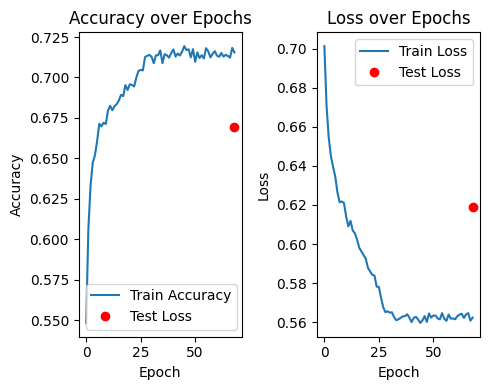

In [6]:
import matplotlib.pyplot as plt

train_acc = train_results.metrics.extra["accuracy_history"]
train_loss = train_results.metrics.extra["loss_history"]
test_acc = test_results.accuracy
test_loss = test_results.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  model_class: "GRUD"
  target_folder: "./target_GRUD"
  data_path: "./data/GRUD_data/dataset.pkl"
  ```

In [7]:
import os
import sys
from leakpro import LeakPro
from mimic_model_handler import GRUHandler as InputHandler

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it

# Read the config file
config_path = "audit.yaml"

# Instantiate leakpro object
leakpro = LeakPro(InputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(return_results=True)

2025-05-22 08:59:22,811 INFO     Target model blueprint created from GRUD in ./target_models.py.
05/22/2025 08:59:22:INFO:Target model blueprint created from GRUD in ./target_models.py.
2025-05-22 08:59:22,821 INFO     Loaded target model metadata from ./target_GRUD/model_metadata.pkl
05/22/2025 08:59:22:INFO:Loaded target model metadata from ./target_GRUD/model_metadata.pkl
/home/fazeleh/LeakPro/leakpro/input_handler/mia_handler.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded vi

Epoch: 0, train_loss: 0.71246603, train_acc: 0.54218881


Training Progress:   1%|          | 2/200 [00:01<02:37,  1.26it/s]

Epoch: 1, train_loss: 0.70980535, train_acc: 0.53132832


Training Progress:   2%|▏         | 3/200 [00:02<02:33,  1.28it/s]

Epoch: 2, train_loss: 0.69594353, train_acc: 0.55889724


Training Progress:   2%|▏         | 4/200 [00:03<02:31,  1.29it/s]

Epoch: 3, train_loss: 0.6774065, train_acc: 0.58646617


Training Progress:   2%|▎         | 5/200 [00:03<02:30,  1.30it/s]

Epoch: 4, train_loss: 0.68156699, train_acc: 0.58897243


Training Progress:   3%|▎         | 6/200 [00:04<02:28,  1.31it/s]

Epoch: 5, train_loss: 0.68015376, train_acc: 0.5914787


Training Progress:   4%|▎         | 7/200 [00:05<02:27,  1.31it/s]

Epoch: 6, train_loss: 0.66413269, train_acc: 0.60484545


Training Progress:   4%|▍         | 8/200 [00:06<02:26,  1.31it/s]

Epoch: 7, train_loss: 0.66467918, train_acc: 0.6106934


Training Progress:   4%|▍         | 9/200 [00:06<02:25,  1.31it/s]

Epoch: 8, train_loss: 0.67272066, train_acc: 0.60233918


Training Progress:   5%|▌         | 10/200 [00:07<02:25,  1.31it/s]

Epoch: 9, train_loss: 0.65636291, train_acc: 0.63575606


Training Progress:   6%|▌         | 11/200 [00:08<02:24,  1.31it/s]

Epoch: 10, train_loss: 0.64646533, train_acc: 0.63324979


Training Progress:   6%|▌         | 12/200 [00:09<02:23,  1.31it/s]

Epoch: 11, train_loss: 0.64613541, train_acc: 0.64243943


Training Progress:   6%|▋         | 13/200 [00:09<02:22,  1.31it/s]

Epoch: 12, train_loss: 0.6464725, train_acc: 0.63241437


Training Progress:   7%|▋         | 14/200 [00:10<02:21,  1.31it/s]

Epoch: 13, train_loss: 0.63891006, train_acc: 0.65079365


Training Progress:   8%|▊         | 15/200 [00:11<02:21,  1.31it/s]

Epoch: 14, train_loss: 0.63717305, train_acc: 0.64160401


Training Progress:   8%|▊         | 16/200 [00:12<02:20,  1.31it/s]

Epoch: 15, train_loss: 0.62185546, train_acc: 0.66248956


Training Progress:   8%|▊         | 17/200 [00:13<02:18,  1.32it/s]

Epoch: 16, train_loss: 0.62528743, train_acc: 0.67669173


Training Progress:   9%|▉         | 18/200 [00:13<02:18,  1.32it/s]

Epoch: 17, train_loss: 0.62751749, train_acc: 0.66499582


Training Progress:  10%|▉         | 19/200 [00:14<02:17,  1.32it/s]

Epoch: 18, train_loss: 0.62766963, train_acc: 0.66499582


Training Progress:  10%|█         | 20/200 [00:15<02:16,  1.32it/s]

Epoch: 19, train_loss: 0.6147983, train_acc: 0.67335004


Training Progress:  10%|█         | 21/200 [00:16<02:15,  1.32it/s]

Epoch: 20, train_loss: 0.62396821, train_acc: 0.6641604


Training Progress:  11%|█         | 22/200 [00:16<02:15,  1.32it/s]

Epoch: 21, train_loss: 0.61163877, train_acc: 0.67669173


Training Progress:  12%|█▏        | 23/200 [00:17<02:14,  1.32it/s]

Epoch: 22, train_loss: 0.60744851, train_acc: 0.69423559


Training Progress:  12%|█▏        | 24/200 [00:18<02:13,  1.32it/s]

Epoch: 23, train_loss: 0.61140402, train_acc: 0.67418546


Training Progress:  12%|█▎        | 25/200 [00:19<02:12,  1.32it/s]

Epoch: 24, train_loss: 0.61046796, train_acc: 0.68922306


Training Progress:  13%|█▎        | 26/200 [00:19<02:11,  1.32it/s]

Epoch: 25, train_loss: 0.60897424, train_acc: 0.68003342


Training Progress:  14%|█▎        | 27/200 [00:20<02:11,  1.32it/s]

Epoch: 26, train_loss: 0.60213994, train_acc: 0.68086884


Training Progress:  14%|█▍        | 28/200 [00:21<02:10,  1.32it/s]

Epoch: 27, train_loss: 0.60472296, train_acc: 0.6833751


Training Progress:  14%|█▍        | 29/200 [00:22<02:09,  1.32it/s]

Epoch: 28, train_loss: 0.59938489, train_acc: 0.6984127


Training Progress:  15%|█▌        | 30/200 [00:22<02:09,  1.32it/s]

Epoch: 29, train_loss: 0.59665196, train_acc: 0.69005848


Training Progress:  16%|█▌        | 31/200 [00:23<02:08,  1.32it/s]

Epoch: 30, train_loss: 0.59547876, train_acc: 0.69172932


Training Progress:  16%|█▌        | 32/200 [00:24<02:07,  1.32it/s]

Epoch: 31, train_loss: 0.58347609, train_acc: 0.70676692


Training Progress:  16%|█▋        | 33/200 [00:25<02:06,  1.32it/s]

Epoch: 32, train_loss: 0.5934419, train_acc: 0.70509607


Training Progress:  17%|█▋        | 34/200 [00:25<02:06,  1.32it/s]

Epoch: 33, train_loss: 0.59108597, train_acc: 0.70008354


Training Progress:  18%|█▊        | 35/200 [00:26<02:06,  1.31it/s]

Epoch: 34, train_loss: 0.58522882, train_acc: 0.70342523


Training Progress:  18%|█▊        | 36/200 [00:27<02:05,  1.31it/s]

Epoch: 35, train_loss: 0.5776019, train_acc: 0.72180451


Training Progress:  18%|█▊        | 37/200 [00:28<02:04,  1.31it/s]

Epoch: 36, train_loss: 0.58229708, train_acc: 0.7059315


Training Progress:  19%|█▉        | 38/200 [00:28<02:03,  1.32it/s]

Epoch: 37, train_loss: 0.57395232, train_acc: 0.70008354


Training Progress:  20%|█▉        | 39/200 [00:29<02:02,  1.32it/s]

Epoch: 38, train_loss: 0.58278679, train_acc: 0.70843776


Training Progress:  20%|██        | 40/200 [00:30<02:01,  1.32it/s]

Epoch: 39, train_loss: 0.56946818, train_acc: 0.71929825


Training Progress:  20%|██        | 41/200 [00:31<02:00,  1.32it/s]

Epoch: 40, train_loss: 0.57196387, train_acc: 0.71595656


Training Progress:  21%|██        | 42/200 [00:32<02:04,  1.27it/s]

Epoch: 41, train_loss: 0.56775067, train_acc: 0.7059315


Training Progress:  22%|██▏       | 43/200 [00:32<02:06,  1.24it/s]

Epoch: 42, train_loss: 0.56930485, train_acc: 0.72096909


Training Progress:  22%|██▏       | 44/200 [00:33<02:01,  1.29it/s]

Epoch: 43, train_loss: 0.56831846, train_acc: 0.73182957


Training Progress:  22%|██▎       | 45/200 [00:34<02:01,  1.28it/s]

Epoch: 44, train_loss: 0.55691096, train_acc: 0.72431078


Training Progress:  23%|██▎       | 46/200 [00:35<02:00,  1.28it/s]

Epoch: 45, train_loss: 0.56438069, train_acc: 0.73099415


Training Progress:  24%|██▎       | 47/200 [00:36<01:59,  1.28it/s]

Epoch: 46, train_loss: 0.56437754, train_acc: 0.72347536


Training Progress:  24%|██▍       | 48/200 [00:36<01:58,  1.28it/s]

Epoch: 47, train_loss: 0.54989743, train_acc: 0.72598162


Training Progress:  24%|██▍       | 49/200 [00:37<01:57,  1.29it/s]

Epoch: 48, train_loss: 0.55456619, train_acc: 0.73600668


Training Progress:  25%|██▌       | 50/200 [00:38<01:56,  1.29it/s]

Epoch: 49, train_loss: 0.53721778, train_acc: 0.732665


Training Progress:  26%|██▌       | 51/200 [00:39<01:56,  1.28it/s]

Epoch: 50, train_loss: 0.55560481, train_acc: 0.72848789


Training Progress:  26%|██▌       | 52/200 [00:39<01:55,  1.28it/s]

Epoch: 51, train_loss: 0.54397866, train_acc: 0.73015873


Training Progress:  26%|██▋       | 53/200 [00:40<01:54,  1.29it/s]

Epoch: 52, train_loss: 0.54511973, train_acc: 0.73767753


Training Progress:  27%|██▋       | 54/200 [00:41<01:52,  1.29it/s]

Epoch: 53, train_loss: 0.5436063, train_acc: 0.73015873


Training Progress:  28%|██▊       | 55/200 [00:42<01:52,  1.29it/s]

Epoch: 54, train_loss: 0.54642906, train_acc: 0.73767753


Training Progress:  28%|██▊       | 56/200 [00:42<01:51,  1.30it/s]

Epoch: 55, train_loss: 0.52815033, train_acc: 0.75355054


Training Progress:  28%|██▊       | 57/200 [00:43<01:50,  1.30it/s]

Epoch: 56, train_loss: 0.52889969, train_acc: 0.75856307


Training Progress:  29%|██▉       | 58/200 [00:44<01:49,  1.30it/s]

Epoch: 57, train_loss: 0.53393512, train_acc: 0.73182957


Training Progress:  30%|██▉       | 59/200 [00:45<01:48,  1.29it/s]

Epoch: 58, train_loss: 0.52749221, train_acc: 0.74770259


Training Progress:  30%|███       | 60/200 [00:46<01:48,  1.29it/s]

Epoch: 59, train_loss: 0.52873669, train_acc: 0.74185464


Training Progress:  30%|███       | 61/200 [00:46<01:47,  1.29it/s]

Epoch: 60, train_loss: 0.51931313, train_acc: 0.75104428


Training Progress:  31%|███       | 62/200 [00:47<01:47,  1.29it/s]

Epoch: 61, train_loss: 0.52500228, train_acc: 0.74770259


Training Progress:  32%|███▏      | 63/200 [00:48<01:46,  1.29it/s]

Epoch: 62, train_loss: 0.5135233, train_acc: 0.76106934


Training Progress:  32%|███▏      | 64/200 [00:49<01:45,  1.29it/s]

Epoch: 63, train_loss: 0.51086222, train_acc: 0.76190476


Training Progress:  32%|███▎      | 65/200 [00:49<01:44,  1.29it/s]

Epoch: 64, train_loss: 0.51840846, train_acc: 0.75522139


Training Progress:  33%|███▎      | 66/200 [00:50<01:44,  1.29it/s]

Epoch: 65, train_loss: 0.51030162, train_acc: 0.76106934


Training Progress:  34%|███▎      | 67/200 [00:51<01:43,  1.28it/s]

Epoch: 66, train_loss: 0.50786606, train_acc: 0.75856307


Training Progress:  34%|███▍      | 68/200 [00:52<01:42,  1.28it/s]

Epoch: 67, train_loss: 0.49033039, train_acc: 0.76524645


Training Progress:  34%|███▍      | 69/200 [00:53<01:42,  1.28it/s]

Epoch: 68, train_loss: 0.51744651, train_acc: 0.76441103


Training Progress:  35%|███▌      | 70/200 [00:53<01:41,  1.28it/s]

Epoch: 69, train_loss: 0.5112536, train_acc: 0.75271512


Training Progress:  36%|███▌      | 71/200 [00:54<01:40,  1.28it/s]

Epoch: 70, train_loss: 0.48738749, train_acc: 0.75020886


Training Progress:  36%|███▌      | 72/200 [00:55<01:40,  1.28it/s]

Epoch: 71, train_loss: 0.49119789, train_acc: 0.76023392


Training Progress:  36%|███▋      | 73/200 [00:56<01:39,  1.28it/s]

Epoch: 72, train_loss: 0.48722498, train_acc: 0.77527151


Training Progress:  37%|███▋      | 74/200 [00:56<01:38,  1.28it/s]

Epoch: 73, train_loss: 0.48577182, train_acc: 0.77025898


Training Progress:  38%|███▊      | 75/200 [00:57<01:37,  1.28it/s]

Epoch: 74, train_loss: 0.4820275, train_acc: 0.77360067


Training Progress:  38%|███▊      | 76/200 [00:58<01:37,  1.28it/s]

Epoch: 75, train_loss: 0.48465736, train_acc: 0.76691729


Training Progress:  38%|███▊      | 77/200 [00:59<01:36,  1.28it/s]

Epoch: 76, train_loss: 0.47654312, train_acc: 0.77610693


Training Progress:  39%|███▉      | 78/200 [01:00<01:35,  1.28it/s]

Epoch: 77, train_loss: 0.47491667, train_acc: 0.76775272


Training Progress:  40%|███▉      | 79/200 [01:00<01:34,  1.28it/s]

Epoch: 78, train_loss: 0.46728411, train_acc: 0.77777778


Training Progress:  40%|████      | 80/200 [01:01<01:33,  1.28it/s]

Epoch: 79, train_loss: 0.46885365, train_acc: 0.77694236


Training Progress:  40%|████      | 81/200 [01:02<01:32,  1.28it/s]

Epoch: 80, train_loss: 0.46796898, train_acc: 0.7786132


Training Progress:  41%|████      | 82/200 [01:03<01:32,  1.28it/s]

Epoch: 81, train_loss: 0.46148997, train_acc: 0.78863826


Training Progress:  42%|████▏     | 83/200 [01:04<01:31,  1.28it/s]

Epoch: 82, train_loss: 0.45419353, train_acc: 0.78529657


Training Progress:  42%|████▏     | 84/200 [01:04<01:30,  1.28it/s]

Epoch: 83, train_loss: 0.44509182, train_acc: 0.79365079


Training Progress:  42%|████▎     | 85/200 [01:05<01:29,  1.28it/s]

Epoch: 84, train_loss: 0.45441712, train_acc: 0.78947368


Training Progress:  43%|████▎     | 86/200 [01:06<01:29,  1.28it/s]

Epoch: 85, train_loss: 0.43791075, train_acc: 0.78780284


Training Progress:  44%|████▎     | 87/200 [01:07<01:28,  1.28it/s]

Epoch: 86, train_loss: 0.43911095, train_acc: 0.79532164


Training Progress:  44%|████▍     | 88/200 [01:07<01:27,  1.28it/s]

Epoch: 87, train_loss: 0.44104655, train_acc: 0.79281537


Training Progress:  44%|████▍     | 89/200 [01:08<01:26,  1.28it/s]

Epoch: 88, train_loss: 0.43364576, train_acc: 0.79197995


Training Progress:  45%|████▌     | 90/200 [01:09<01:25,  1.29it/s]

Epoch: 89, train_loss: 0.43430957, train_acc: 0.79615706


Training Progress:  46%|████▌     | 91/200 [01:10<01:24,  1.29it/s]

Epoch: 90, train_loss: 0.42356633, train_acc: 0.80367586


Training Progress:  46%|████▌     | 92/200 [01:11<01:23,  1.29it/s]

Epoch: 91, train_loss: 0.41821391, train_acc: 0.81119465


Training Progress:  46%|████▋     | 93/200 [01:11<01:22,  1.30it/s]

Epoch: 92, train_loss: 0.41403316, train_acc: 0.80785297


Training Progress:  47%|████▋     | 94/200 [01:12<01:21,  1.30it/s]

Epoch: 93, train_loss: 0.41515192, train_acc: 0.80952381


Training Progress:  48%|████▊     | 95/200 [01:13<01:20,  1.30it/s]

Epoch: 94, train_loss: 0.40571802, train_acc: 0.81453634


Training Progress:  48%|████▊     | 96/200 [01:14<01:20,  1.30it/s]

Epoch: 95, train_loss: 0.40108054, train_acc: 0.82038429


Training Progress:  48%|████▊     | 97/200 [01:14<01:19,  1.30it/s]

Epoch: 96, train_loss: 0.39958326, train_acc: 0.80952381


Training Progress:  49%|████▉     | 98/200 [01:15<01:18,  1.30it/s]

Epoch: 97, train_loss: 0.38835824, train_acc: 0.82623225


Training Progress:  50%|████▉     | 99/200 [01:16<01:17,  1.30it/s]

Epoch: 98, train_loss: 0.3859771, train_acc: 0.8320802


Training Progress:  50%|█████     | 100/200 [01:17<01:16,  1.30it/s]

Epoch: 99, train_loss: 0.37527921, train_acc: 0.83625731


Training Progress:  50%|█████     | 101/200 [01:17<01:16,  1.30it/s]

Epoch: 100, train_loss: 0.36929772, train_acc: 0.85045948


Training Progress:  51%|█████     | 102/200 [01:18<01:15,  1.30it/s]

Epoch: 101, train_loss: 0.35429991, train_acc: 0.85296575


Training Progress:  52%|█████▏    | 103/200 [01:19<01:14,  1.30it/s]

Epoch: 102, train_loss: 0.35569537, train_acc: 0.85380117


Training Progress:  52%|█████▏    | 104/200 [01:20<01:13,  1.30it/s]

Epoch: 103, train_loss: 0.34392136, train_acc: 0.8588137


Training Progress:  52%|█████▎    | 105/200 [01:21<01:13,  1.30it/s]

Epoch: 104, train_loss: 0.34340708, train_acc: 0.85964912


Training Progress:  53%|█████▎    | 106/200 [01:21<01:12,  1.30it/s]

Epoch: 105, train_loss: 0.33530301, train_acc: 0.86131997


Training Progress:  54%|█████▎    | 107/200 [01:22<01:11,  1.30it/s]

Epoch: 106, train_loss: 0.32279208, train_acc: 0.86967419


Training Progress:  54%|█████▍    | 108/200 [01:23<01:10,  1.30it/s]

Epoch: 107, train_loss: 0.31668393, train_acc: 0.87050961


Training Progress:  55%|█████▍    | 109/200 [01:24<01:09,  1.30it/s]

Epoch: 108, train_loss: 0.30993008, train_acc: 0.88387636


Training Progress:  55%|█████▌    | 110/200 [01:24<01:09,  1.30it/s]

Epoch: 109, train_loss: 0.30536475, train_acc: 0.88137009


Training Progress:  56%|█████▌    | 111/200 [01:25<01:08,  1.30it/s]

Epoch: 110, train_loss: 0.29136776, train_acc: 0.89557226


Training Progress:  56%|█████▌    | 112/200 [01:26<01:07,  1.30it/s]

Epoch: 111, train_loss: 0.2857195, train_acc: 0.89640769


Training Progress:  56%|█████▋    | 113/200 [01:27<01:06,  1.30it/s]

Epoch: 112, train_loss: 0.27747376, train_acc: 0.89640769


Training Progress:  57%|█████▋    | 114/200 [01:27<01:06,  1.30it/s]

Epoch: 113, train_loss: 0.26193829, train_acc: 0.90559733


Training Progress:  57%|█████▊    | 115/200 [01:28<01:05,  1.30it/s]

Epoch: 114, train_loss: 0.25715855, train_acc: 0.91729323


Training Progress:  58%|█████▊    | 116/200 [01:29<01:04,  1.30it/s]

Epoch: 115, train_loss: 0.25073425, train_acc: 0.91395155


Training Progress:  58%|█████▊    | 117/200 [01:30<01:03,  1.30it/s]

Epoch: 116, train_loss: 0.24321046, train_acc: 0.91729323


Training Progress:  59%|█████▉    | 118/200 [01:31<01:03,  1.30it/s]

Epoch: 117, train_loss: 0.23564878, train_acc: 0.92397661


Training Progress:  60%|█████▉    | 119/200 [01:31<01:02,  1.30it/s]

Epoch: 118, train_loss: 0.22755437, train_acc: 0.91812865


Training Progress:  60%|██████    | 120/200 [01:32<01:01,  1.30it/s]

Epoch: 119, train_loss: 0.21448157, train_acc: 0.92898914


Training Progress:  60%|██████    | 121/200 [01:33<01:00,  1.30it/s]

Epoch: 120, train_loss: 0.20199659, train_acc: 0.94486216


Training Progress:  61%|██████    | 122/200 [01:34<01:00,  1.30it/s]

Epoch: 121, train_loss: 0.19406325, train_acc: 0.946533


Training Progress:  62%|██████▏   | 123/200 [01:34<00:59,  1.30it/s]

Epoch: 122, train_loss: 0.19177529, train_acc: 0.94569758


Training Progress:  62%|██████▏   | 124/200 [01:35<00:58,  1.30it/s]

Epoch: 123, train_loss: 0.18066767, train_acc: 0.946533


Training Progress:  62%|██████▎   | 125/200 [01:36<00:57,  1.30it/s]

Epoch: 124, train_loss: 0.17305466, train_acc: 0.95071011


Training Progress:  63%|██████▎   | 126/200 [01:37<00:56,  1.30it/s]

Epoch: 125, train_loss: 0.1666105, train_acc: 0.95488722


Training Progress:  64%|██████▎   | 127/200 [01:37<00:56,  1.30it/s]

Epoch: 126, train_loss: 0.15511105, train_acc: 0.96491228


Training Progress:  64%|██████▍   | 128/200 [01:38<00:55,  1.30it/s]

Epoch: 127, train_loss: 0.14880565, train_acc: 0.96658312


Training Progress:  64%|██████▍   | 129/200 [01:39<00:54,  1.30it/s]

Epoch: 128, train_loss: 0.14415581, train_acc: 0.96908939


Training Progress:  65%|██████▌   | 130/200 [01:40<00:53,  1.30it/s]

Epoch: 129, train_loss: 0.1381774, train_acc: 0.96741855


Training Progress:  66%|██████▌   | 131/200 [01:41<00:52,  1.30it/s]

Epoch: 130, train_loss: 0.13033023, train_acc: 0.9732665


Training Progress:  66%|██████▌   | 132/200 [01:41<00:52,  1.30it/s]

Epoch: 131, train_loss: 0.12519942, train_acc: 0.97410192


Training Progress:  66%|██████▋   | 133/200 [01:42<00:51,  1.30it/s]

Epoch: 132, train_loss: 0.1220357, train_acc: 0.97076023


Training Progress:  67%|██████▋   | 134/200 [01:43<00:50,  1.30it/s]

Epoch: 133, train_loss: 0.11223613, train_acc: 0.97660819


Training Progress:  68%|██████▊   | 135/200 [01:44<00:50,  1.30it/s]

Epoch: 134, train_loss: 0.10853559, train_acc: 0.97744361


Training Progress:  68%|██████▊   | 136/200 [01:44<00:49,  1.30it/s]

Epoch: 135, train_loss: 0.10125476, train_acc: 0.98245614


Training Progress:  68%|██████▊   | 137/200 [01:45<00:48,  1.30it/s]

Epoch: 136, train_loss: 0.09588697, train_acc: 0.98663325


Training Progress:  69%|██████▉   | 138/200 [01:46<00:47,  1.30it/s]

Epoch: 137, train_loss: 0.09203222, train_acc: 0.98412698


Training Progress:  70%|██████▉   | 139/200 [01:47<00:46,  1.30it/s]

Epoch: 138, train_loss: 0.0841191, train_acc: 0.98663325


Training Progress:  70%|███████   | 140/200 [01:47<00:46,  1.30it/s]

Epoch: 139, train_loss: 0.08045998, train_acc: 0.98579783


Training Progress:  70%|███████   | 141/200 [01:48<00:45,  1.30it/s]

Epoch: 140, train_loss: 0.0781088, train_acc: 0.98746867


Training Progress:  71%|███████   | 142/200 [01:49<00:44,  1.30it/s]

Epoch: 141, train_loss: 0.07219082, train_acc: 0.98830409


Training Progress:  72%|███████▏  | 143/200 [01:50<00:43,  1.30it/s]

Epoch: 142, train_loss: 0.06594581, train_acc: 0.98913952


Training Progress:  72%|███████▏  | 144/200 [01:51<00:43,  1.30it/s]

Epoch: 143, train_loss: 0.06349741, train_acc: 0.99081036


Training Progress:  72%|███████▎  | 145/200 [01:51<00:42,  1.30it/s]

Epoch: 144, train_loss: 0.06132194, train_acc: 0.99331662


Training Progress:  73%|███████▎  | 146/200 [01:52<00:41,  1.30it/s]

Epoch: 145, train_loss: 0.05523033, train_acc: 0.99498747


Training Progress:  74%|███████▎  | 147/200 [01:53<00:40,  1.30it/s]

Epoch: 146, train_loss: 0.05165013, train_acc: 0.99498747


Training Progress:  74%|███████▍  | 148/200 [01:54<00:40,  1.30it/s]

Epoch: 147, train_loss: 0.04928471, train_acc: 0.99331662


Training Progress:  74%|███████▍  | 149/200 [01:54<00:39,  1.30it/s]

Epoch: 148, train_loss: 0.04563869, train_acc: 0.99582289


Training Progress:  75%|███████▌  | 150/200 [01:55<00:38,  1.30it/s]

Epoch: 149, train_loss: 0.04411918, train_acc: 0.99498747


Training Progress:  76%|███████▌  | 151/200 [01:56<00:37,  1.30it/s]

Epoch: 150, train_loss: 0.04205693, train_acc: 0.99498747


Training Progress:  76%|███████▌  | 152/200 [01:57<00:36,  1.30it/s]

Epoch: 151, train_loss: 0.03930786, train_acc: 0.99498747


Training Progress:  76%|███████▋  | 153/200 [01:57<00:36,  1.30it/s]

Epoch: 152, train_loss: 0.03647269, train_acc: 0.99582289


Training Progress:  77%|███████▋  | 154/200 [01:58<00:35,  1.30it/s]

Epoch: 153, train_loss: 0.03358772, train_acc: 0.99665831


Training Progress:  78%|███████▊  | 155/200 [01:59<00:34,  1.30it/s]

Epoch: 154, train_loss: 0.0328031, train_acc: 0.99498747


Training Progress:  78%|███████▊  | 156/200 [02:00<00:33,  1.30it/s]

Epoch: 155, train_loss: 0.02905348, train_acc: 0.99749373


Training Progress:  78%|███████▊  | 157/200 [02:01<00:33,  1.30it/s]

Epoch: 156, train_loss: 0.02669551, train_acc: 0.99832916


Training Progress:  79%|███████▉  | 158/200 [02:01<00:32,  1.30it/s]

Epoch: 157, train_loss: 0.02454963, train_acc: 0.99832916


Training Progress:  80%|███████▉  | 159/200 [02:02<00:31,  1.30it/s]

Epoch: 158, train_loss: 0.0229471, train_acc: 0.99916458


Training Progress:  80%|████████  | 160/200 [02:03<00:30,  1.30it/s]

Epoch: 159, train_loss: 0.02302601, train_acc: 0.99832916


Training Progress:  80%|████████  | 161/200 [02:04<00:30,  1.30it/s]

Epoch: 160, train_loss: 0.02122563, train_acc: 0.99832916


Training Progress:  81%|████████  | 162/200 [02:04<00:29,  1.30it/s]

Epoch: 161, train_loss: 0.02050017, train_acc: 0.99749373


Training Progress:  82%|████████▏ | 163/200 [02:05<00:28,  1.30it/s]

Epoch: 162, train_loss: 0.01898886, train_acc: 0.99916458


Training Progress:  82%|████████▏ | 164/200 [02:06<00:27,  1.30it/s]

Epoch: 163, train_loss: 0.01855765, train_acc: 0.99916458


Training Progress:  82%|████████▎ | 165/200 [02:07<00:26,  1.30it/s]

Epoch: 164, train_loss: 0.01724338, train_acc: 1.0


Training Progress:  83%|████████▎ | 166/200 [02:07<00:26,  1.30it/s]

Epoch: 165, train_loss: 0.01674534, train_acc: 0.99916458


Training Progress:  84%|████████▎ | 167/200 [02:08<00:25,  1.30it/s]

Epoch: 166, train_loss: 0.01615759, train_acc: 0.99916458


Training Progress:  84%|████████▍ | 168/200 [02:09<00:24,  1.31it/s]

Epoch: 167, train_loss: 0.01570779, train_acc: 0.99916458


Training Progress:  84%|████████▍ | 169/200 [02:10<00:23,  1.31it/s]

Epoch: 168, train_loss: 0.01561781, train_acc: 0.99832916


Training Progress:  85%|████████▌ | 170/200 [02:11<00:22,  1.31it/s]

Epoch: 169, train_loss: 0.01520016, train_acc: 0.99916458


Training Progress:  86%|████████▌ | 171/200 [02:11<00:22,  1.31it/s]

Epoch: 170, train_loss: 0.01476934, train_acc: 0.99832916


Training Progress:  86%|████████▌ | 172/200 [02:12<00:21,  1.31it/s]

Epoch: 171, train_loss: 0.01367559, train_acc: 1.0


Training Progress:  86%|████████▋ | 173/200 [02:13<00:20,  1.31it/s]

Epoch: 172, train_loss: 0.01352919, train_acc: 0.99916458


Training Progress:  87%|████████▋ | 174/200 [02:14<00:19,  1.31it/s]

Epoch: 173, train_loss: 0.01389718, train_acc: 0.99832916


Training Progress:  88%|████████▊ | 175/200 [02:14<00:19,  1.31it/s]

Epoch: 174, train_loss: 0.01291113, train_acc: 0.99832916


Training Progress:  88%|████████▊ | 176/200 [02:15<00:18,  1.31it/s]

Epoch: 175, train_loss: 0.01236019, train_acc: 1.0


Training Progress:  88%|████████▊ | 177/200 [02:16<00:17,  1.31it/s]

Epoch: 176, train_loss: 0.01227603, train_acc: 1.0


Training Progress:  89%|████████▉ | 178/200 [02:17<00:16,  1.31it/s]

Epoch: 177, train_loss: 0.0126005, train_acc: 0.99916458


Training Progress:  90%|████████▉ | 179/200 [02:17<00:16,  1.31it/s]

Epoch: 178, train_loss: 0.01202068, train_acc: 1.0


Training Progress:  90%|█████████ | 180/200 [02:18<00:15,  1.31it/s]

Epoch: 179, train_loss: 0.01157544, train_acc: 1.0


Training Progress:  90%|█████████ | 181/200 [02:19<00:14,  1.31it/s]

Epoch: 180, train_loss: 0.01105297, train_acc: 1.0


Training Progress:  91%|█████████ | 182/200 [02:20<00:13,  1.31it/s]

Epoch: 181, train_loss: 0.01114108, train_acc: 1.0


Training Progress:  92%|█████████▏| 183/200 [02:20<00:12,  1.31it/s]

Epoch: 182, train_loss: 0.01013138, train_acc: 1.0


Training Progress:  92%|█████████▏| 184/200 [02:21<00:12,  1.31it/s]

Epoch: 183, train_loss: 0.01082042, train_acc: 0.99916458


Training Progress:  92%|█████████▎| 185/200 [02:22<00:11,  1.31it/s]

Epoch: 184, train_loss: 0.01053306, train_acc: 1.0


Training Progress:  93%|█████████▎| 186/200 [02:23<00:10,  1.31it/s]

Epoch: 185, train_loss: 0.01019518, train_acc: 1.0


Training Progress:  94%|█████████▎| 187/200 [02:24<00:09,  1.31it/s]

Epoch: 186, train_loss: 0.00984779, train_acc: 1.0


Training Progress:  94%|█████████▍| 188/200 [02:24<00:09,  1.31it/s]

Epoch: 187, train_loss: 0.00959341, train_acc: 1.0


Training Progress:  94%|█████████▍| 189/200 [02:25<00:08,  1.31it/s]

Epoch: 188, train_loss: 0.00943937, train_acc: 1.0


Training Progress:  95%|█████████▌| 190/200 [02:26<00:07,  1.31it/s]

Epoch: 189, train_loss: 0.00934274, train_acc: 1.0


Training Progress:  96%|█████████▌| 191/200 [02:27<00:06,  1.31it/s]

Epoch: 190, train_loss: 0.01070039, train_acc: 0.99916458


Training Progress:  96%|█████████▌| 192/200 [02:27<00:06,  1.31it/s]

Epoch: 191, train_loss: 0.11434736, train_acc: 0.9657477


Training Progress:  96%|█████████▋| 193/200 [02:28<00:05,  1.31it/s]

Epoch: 192, train_loss: 0.07531193, train_acc: 0.97660819


Training Progress:  97%|█████████▋| 194/200 [02:29<00:04,  1.31it/s]

Epoch: 193, train_loss: 0.0527821, train_acc: 0.98329156


Training Progress:  98%|█████████▊| 195/200 [02:30<00:03,  1.26it/s]

Epoch: 194, train_loss: 0.03500972, train_acc: 0.99164578


Training Progress:  98%|█████████▊| 196/200 [02:31<00:03,  1.21it/s]

Epoch: 195, train_loss: 0.02081128, train_acc: 0.99582289


Training Progress:  98%|█████████▊| 197/200 [02:32<00:02,  1.17it/s]

Epoch: 196, train_loss: 0.0134077, train_acc: 1.0


Training Progress:  99%|█████████▉| 198/200 [02:32<00:01,  1.15it/s]

Epoch: 197, train_loss: 0.01242459, train_acc: 1.0


Training Progress: 100%|█████████▉| 199/200 [02:33<00:00,  1.14it/s]

Epoch: 198, train_loss: 0.01153868, train_acc: 1.0


Training Progress: 100%|██████████| 200/200 [02:34<00:00,  1.29it/s]


Epoch: 199, train_loss: 0.01078045, train_acc: 1.0


2025-05-22 09:01:58,773 INFO     Training shadow model 27 complete
05/22/2025 09:01:58:INFO:Training shadow model 27 complete
2025-05-22 09:01:58,777 INFO     Saved shadow model 27 to ./leakpro_output/attack_objects/shadow_model
05/22/2025 09:01:58:INFO:Saved shadow model 27 to ./leakpro_output/attack_objects/shadow_model
2025-05-22 09:01:58,778 INFO     Storing metadata for shadow model 27
05/22/2025 09:01:58:INFO:Storing metadata for shadow model 27
2025-05-22 09:01:58,796 INFO     Metadata for shadow model 27:
init_params={'input_size': 104, 'hidden_size': 150, 'X_mean': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), 'batch_size': 59, 'bn_flag': True, 'output_last': False} train_indices=[23420, 22258, 22348, 22706, 21575, 23826, 21770, 21759, 21904, 2168

Epoch: 0, train_loss: 0.73201187, train_acc: 0.49707602


Training Progress:   1%|          | 2/200 [00:01<02:36,  1.27it/s]

Epoch: 1, train_loss: 0.72404852, train_acc: 0.5154553


Training Progress:   2%|▏         | 3/200 [00:02<02:33,  1.28it/s]

Epoch: 2, train_loss: 0.71741503, train_acc: 0.53216374


Training Progress:   2%|▏         | 4/200 [00:03<02:31,  1.29it/s]

Epoch: 3, train_loss: 0.71871152, train_acc: 0.53383459


Training Progress:   2%|▎         | 5/200 [00:03<02:30,  1.30it/s]

Epoch: 4, train_loss: 0.69913417, train_acc: 0.55555556


Training Progress:   3%|▎         | 6/200 [00:04<02:29,  1.30it/s]

Epoch: 5, train_loss: 0.68551251, train_acc: 0.56975773


Training Progress:   4%|▎         | 7/200 [00:05<02:28,  1.30it/s]

Epoch: 6, train_loss: 0.68247423, train_acc: 0.58061821


Training Progress:   4%|▍         | 8/200 [00:06<02:27,  1.30it/s]

Epoch: 7, train_loss: 0.68323578, train_acc: 0.57309942


Training Progress:   4%|▍         | 9/200 [00:06<02:27,  1.29it/s]

Epoch: 8, train_loss: 0.66771473, train_acc: 0.59565581


Training Progress:   5%|▌         | 10/200 [00:07<02:26,  1.29it/s]

Epoch: 9, train_loss: 0.65467885, train_acc: 0.62573099


Training Progress:   6%|▌         | 11/200 [00:08<02:26,  1.29it/s]

Epoch: 10, train_loss: 0.66221717, train_acc: 0.60818713


Training Progress:   6%|▌         | 12/200 [00:09<02:25,  1.29it/s]

Epoch: 11, train_loss: 0.66262977, train_acc: 0.60985798


Training Progress:   6%|▋         | 13/200 [00:10<02:24,  1.29it/s]

Epoch: 12, train_loss: 0.65478928, train_acc: 0.63492063


Training Progress:   7%|▋         | 14/200 [00:10<02:23,  1.29it/s]

Epoch: 13, train_loss: 0.64970389, train_acc: 0.63324979


Training Progress:   8%|▊         | 15/200 [00:11<02:22,  1.29it/s]

Epoch: 14, train_loss: 0.65490474, train_acc: 0.62406015


Training Progress:   8%|▊         | 16/200 [00:12<02:22,  1.29it/s]

Epoch: 15, train_loss: 0.63784614, train_acc: 0.62238931


Training Progress:   8%|▊         | 17/200 [00:13<02:21,  1.30it/s]

Epoch: 16, train_loss: 0.6453982, train_acc: 0.6449457


Training Progress:   9%|▉         | 18/200 [00:13<02:20,  1.30it/s]

Epoch: 17, train_loss: 0.63555734, train_acc: 0.64160401


Training Progress:  10%|▉         | 19/200 [00:14<02:19,  1.30it/s]

Epoch: 18, train_loss: 0.63265574, train_acc: 0.65329992


Training Progress:  10%|█         | 20/200 [00:15<02:18,  1.30it/s]

Epoch: 19, train_loss: 0.62583789, train_acc: 0.65162907


Training Progress:  10%|█         | 21/200 [00:16<02:18,  1.30it/s]

Epoch: 20, train_loss: 0.62301993, train_acc: 0.67335004


Training Progress:  11%|█         | 22/200 [00:17<02:17,  1.29it/s]

Epoch: 21, train_loss: 0.61707894, train_acc: 0.66750209


Training Progress:  12%|█▏        | 23/200 [00:17<02:16,  1.30it/s]

Epoch: 22, train_loss: 0.62612147, train_acc: 0.68421053


Training Progress:  12%|█▏        | 24/200 [00:18<02:15,  1.30it/s]

Epoch: 23, train_loss: 0.60373573, train_acc: 0.68588137


Training Progress:  12%|█▎        | 25/200 [00:19<02:15,  1.30it/s]

Epoch: 24, train_loss: 0.61310105, train_acc: 0.67752715


Training Progress:  13%|█▎        | 26/200 [00:20<02:14,  1.30it/s]

Epoch: 25, train_loss: 0.62038174, train_acc: 0.67335004


Training Progress:  14%|█▎        | 27/200 [00:20<02:13,  1.30it/s]

Epoch: 26, train_loss: 0.62200097, train_acc: 0.65914787


Training Progress:  14%|█▍        | 28/200 [00:21<02:12,  1.30it/s]

Epoch: 27, train_loss: 0.61098757, train_acc: 0.68671679


Training Progress:  14%|█▍        | 29/200 [00:22<02:12,  1.29it/s]

Epoch: 28, train_loss: 0.59726775, train_acc: 0.69674185


Training Progress:  15%|█▌        | 30/200 [00:23<02:11,  1.30it/s]

Epoch: 29, train_loss: 0.5994075, train_acc: 0.69674185


Training Progress:  16%|█▌        | 31/200 [00:23<02:10,  1.30it/s]

Epoch: 30, train_loss: 0.60759281, train_acc: 0.69423559


Training Progress:  16%|█▌        | 32/200 [00:24<02:09,  1.30it/s]

Epoch: 31, train_loss: 0.59441, train_acc: 0.69674185


Training Progress:  16%|█▋        | 33/200 [00:25<02:09,  1.29it/s]

Epoch: 32, train_loss: 0.60389178, train_acc: 0.67669173


Training Progress:  17%|█▋        | 34/200 [00:26<02:08,  1.29it/s]

Epoch: 33, train_loss: 0.60034347, train_acc: 0.69005848


Training Progress:  18%|█▊        | 35/200 [00:27<02:07,  1.29it/s]

Epoch: 34, train_loss: 0.59702751, train_acc: 0.6984127


Training Progress:  18%|█▊        | 36/200 [00:27<02:06,  1.30it/s]

Epoch: 35, train_loss: 0.59039965, train_acc: 0.69256475


Training Progress:  18%|█▊        | 37/200 [00:28<02:05,  1.30it/s]

Epoch: 36, train_loss: 0.59811804, train_acc: 0.70258981


Training Progress:  19%|█▉        | 38/200 [00:29<02:04,  1.30it/s]

Epoch: 37, train_loss: 0.58724769, train_acc: 0.71261487


Training Progress:  20%|█▉        | 39/200 [00:30<02:04,  1.30it/s]

Epoch: 38, train_loss: 0.5925121, train_acc: 0.70342523


Training Progress:  20%|██        | 40/200 [00:30<02:03,  1.30it/s]

Epoch: 39, train_loss: 0.5856157, train_acc: 0.71094403


Training Progress:  20%|██        | 41/200 [00:31<02:02,  1.30it/s]

Epoch: 40, train_loss: 0.57887676, train_acc: 0.71094403


Training Progress:  21%|██        | 42/200 [00:32<02:01,  1.30it/s]

Epoch: 41, train_loss: 0.58038844, train_acc: 0.70843776


Training Progress:  22%|██▏       | 43/200 [00:33<02:01,  1.29it/s]

Epoch: 42, train_loss: 0.57386394, train_acc: 0.71428571


Training Progress:  22%|██▏       | 44/200 [00:33<02:00,  1.29it/s]

Epoch: 43, train_loss: 0.58275547, train_acc: 0.70676692


Training Progress:  22%|██▎       | 45/200 [00:34<01:59,  1.29it/s]

Epoch: 44, train_loss: 0.57706106, train_acc: 0.71177945


Training Progress:  23%|██▎       | 46/200 [00:35<01:58,  1.30it/s]

Epoch: 45, train_loss: 0.57245369, train_acc: 0.71595656


Training Progress:  24%|██▎       | 47/200 [00:36<01:58,  1.30it/s]

Epoch: 46, train_loss: 0.57839215, train_acc: 0.70676692


Training Progress:  24%|██▍       | 48/200 [00:37<01:57,  1.29it/s]

Epoch: 47, train_loss: 0.56834619, train_acc: 0.7059315


Training Progress:  24%|██▍       | 49/200 [00:37<01:56,  1.30it/s]

Epoch: 48, train_loss: 0.56145771, train_acc: 0.72096909


Training Progress:  25%|██▌       | 50/200 [00:38<01:55,  1.30it/s]

Epoch: 49, train_loss: 0.55458278, train_acc: 0.72932331


Training Progress:  26%|██▌       | 51/200 [00:39<01:54,  1.30it/s]

Epoch: 50, train_loss: 0.5661396, train_acc: 0.71846282


Training Progress:  26%|██▌       | 52/200 [00:40<01:54,  1.30it/s]

Epoch: 51, train_loss: 0.55598421, train_acc: 0.72431078


Training Progress:  26%|██▋       | 53/200 [00:40<01:53,  1.30it/s]

Epoch: 52, train_loss: 0.55803369, train_acc: 0.72096909


Training Progress:  27%|██▋       | 54/200 [00:41<01:52,  1.30it/s]

Epoch: 53, train_loss: 0.55997939, train_acc: 0.71345029


Training Progress:  28%|██▊       | 55/200 [00:42<01:51,  1.30it/s]

Epoch: 54, train_loss: 0.54659761, train_acc: 0.73350042


Training Progress:  28%|██▊       | 56/200 [00:43<01:51,  1.30it/s]

Epoch: 55, train_loss: 0.55427509, train_acc: 0.72263993


Training Progress:  28%|██▊       | 57/200 [00:44<01:50,  1.30it/s]

Epoch: 56, train_loss: 0.55131803, train_acc: 0.72598162


Training Progress:  29%|██▉       | 58/200 [00:44<01:49,  1.30it/s]

Epoch: 57, train_loss: 0.54818653, train_acc: 0.73433584


Training Progress:  30%|██▉       | 59/200 [00:45<01:48,  1.29it/s]

Epoch: 58, train_loss: 0.54264195, train_acc: 0.73182957


Training Progress:  30%|███       | 60/200 [00:46<01:48,  1.29it/s]

Epoch: 59, train_loss: 0.54313282, train_acc: 0.74519632


Training Progress:  30%|███       | 61/200 [00:47<01:47,  1.29it/s]

Epoch: 60, train_loss: 0.54213477, train_acc: 0.73934837


Training Progress:  31%|███       | 62/200 [00:47<01:46,  1.29it/s]

Epoch: 61, train_loss: 0.53665267, train_acc: 0.73517126


Training Progress:  32%|███▏      | 63/200 [00:48<01:45,  1.29it/s]

Epoch: 62, train_loss: 0.53507126, train_acc: 0.73517126


Training Progress:  32%|███▏      | 64/200 [00:49<01:45,  1.29it/s]

Epoch: 63, train_loss: 0.53083608, train_acc: 0.73767753


Training Progress:  32%|███▎      | 65/200 [00:50<01:44,  1.29it/s]

Epoch: 64, train_loss: 0.53467547, train_acc: 0.74101921


Training Progress:  33%|███▎      | 66/200 [00:50<01:43,  1.29it/s]

Epoch: 65, train_loss: 0.52677209, train_acc: 0.74519632


Training Progress:  34%|███▎      | 67/200 [00:51<01:42,  1.29it/s]

Epoch: 66, train_loss: 0.53568652, train_acc: 0.73015873


Training Progress:  34%|███▍      | 68/200 [00:52<01:42,  1.29it/s]

Epoch: 67, train_loss: 0.52547741, train_acc: 0.74352548


Training Progress:  34%|███▍      | 69/200 [00:53<01:41,  1.29it/s]

Epoch: 68, train_loss: 0.51955757, train_acc: 0.7443609


Training Progress:  35%|███▌      | 70/200 [00:54<01:40,  1.29it/s]

Epoch: 69, train_loss: 0.51548696, train_acc: 0.74269006


Training Progress:  36%|███▌      | 71/200 [00:54<01:40,  1.29it/s]

Epoch: 70, train_loss: 0.51999739, train_acc: 0.7518797


Training Progress:  36%|███▌      | 72/200 [00:55<01:39,  1.29it/s]

Epoch: 71, train_loss: 0.50681984, train_acc: 0.73934837


Training Progress:  36%|███▋      | 73/200 [00:56<01:38,  1.29it/s]

Epoch: 72, train_loss: 0.51825164, train_acc: 0.75104428


Training Progress:  37%|███▋      | 74/200 [00:57<01:37,  1.29it/s]

Epoch: 73, train_loss: 0.50785625, train_acc: 0.76023392


Training Progress:  38%|███▊      | 75/200 [00:57<01:36,  1.29it/s]

Epoch: 74, train_loss: 0.50342741, train_acc: 0.77610693


Training Progress:  38%|███▊      | 76/200 [00:58<01:35,  1.29it/s]

Epoch: 75, train_loss: 0.5084136, train_acc: 0.76190476


Training Progress:  38%|███▊      | 77/200 [00:59<01:34,  1.30it/s]

Epoch: 76, train_loss: 0.5049238, train_acc: 0.75104428


Training Progress:  39%|███▉      | 78/200 [01:00<01:34,  1.29it/s]

Epoch: 77, train_loss: 0.49786184, train_acc: 0.76190476


Training Progress:  40%|███▉      | 79/200 [01:01<01:33,  1.29it/s]

Epoch: 78, train_loss: 0.49567427, train_acc: 0.76942356


Training Progress:  40%|████      | 80/200 [01:01<01:32,  1.29it/s]

Epoch: 79, train_loss: 0.49983803, train_acc: 0.77025898


Training Progress:  40%|████      | 81/200 [01:02<01:31,  1.29it/s]

Epoch: 80, train_loss: 0.48887197, train_acc: 0.76691729


Training Progress:  41%|████      | 82/200 [01:03<01:31,  1.29it/s]

Epoch: 81, train_loss: 0.4787765, train_acc: 0.77192982


Training Progress:  42%|████▏     | 83/200 [01:04<01:30,  1.29it/s]

Epoch: 82, train_loss: 0.48584754, train_acc: 0.7710944


Training Progress:  42%|████▏     | 84/200 [01:04<01:29,  1.29it/s]

Epoch: 83, train_loss: 0.48646715, train_acc: 0.76691729


Training Progress:  42%|████▎     | 85/200 [01:05<01:28,  1.29it/s]

Epoch: 84, train_loss: 0.47625915, train_acc: 0.7786132


Training Progress:  43%|████▎     | 86/200 [01:06<01:28,  1.29it/s]

Epoch: 85, train_loss: 0.47912216, train_acc: 0.78111947


Training Progress:  44%|████▎     | 87/200 [01:07<01:27,  1.29it/s]

Epoch: 86, train_loss: 0.46774974, train_acc: 0.78446115


Training Progress:  44%|████▍     | 88/200 [01:07<01:26,  1.30it/s]

Epoch: 87, train_loss: 0.47313279, train_acc: 0.78279031


Training Progress:  44%|████▍     | 89/200 [01:08<01:25,  1.29it/s]

Epoch: 88, train_loss: 0.47106203, train_acc: 0.77694236


Training Progress:  45%|████▌     | 90/200 [01:09<01:25,  1.29it/s]

Epoch: 89, train_loss: 0.46459672, train_acc: 0.78028404


Training Progress:  46%|████▌     | 91/200 [01:10<01:24,  1.29it/s]

Epoch: 90, train_loss: 0.45800983, train_acc: 0.79615706


Training Progress:  46%|████▌     | 92/200 [01:11<01:23,  1.30it/s]

Epoch: 91, train_loss: 0.46104255, train_acc: 0.79030911


Training Progress:  46%|████▋     | 93/200 [01:11<01:22,  1.30it/s]

Epoch: 92, train_loss: 0.4546139, train_acc: 0.78696742


Training Progress:  47%|████▋     | 94/200 [01:12<01:21,  1.30it/s]

Epoch: 93, train_loss: 0.44011689, train_acc: 0.79949875


Training Progress:  48%|████▊     | 95/200 [01:13<01:21,  1.29it/s]

Epoch: 94, train_loss: 0.44704789, train_acc: 0.78195489


Training Progress:  48%|████▊     | 96/200 [01:14<01:20,  1.29it/s]

Epoch: 95, train_loss: 0.44309006, train_acc: 0.79699248


Training Progress:  48%|████▊     | 97/200 [01:14<01:19,  1.29it/s]

Epoch: 96, train_loss: 0.43420296, train_acc: 0.80952381


Training Progress:  49%|████▉     | 98/200 [01:15<01:19,  1.29it/s]

Epoch: 97, train_loss: 0.43078736, train_acc: 0.80451128


Training Progress:  50%|████▉     | 99/200 [01:16<01:18,  1.29it/s]

Epoch: 98, train_loss: 0.42819073, train_acc: 0.8053467


Training Progress:  50%|█████     | 100/200 [01:17<01:17,  1.29it/s]

Epoch: 99, train_loss: 0.41838265, train_acc: 0.82121972


Training Progress:  50%|█████     | 101/200 [01:18<01:16,  1.29it/s]

Epoch: 100, train_loss: 0.4108585, train_acc: 0.81704261


Training Progress:  51%|█████     | 102/200 [01:18<01:15,  1.29it/s]

Epoch: 101, train_loss: 0.41107062, train_acc: 0.81453634


Training Progress:  52%|█████▏    | 103/200 [01:19<01:14,  1.29it/s]

Epoch: 102, train_loss: 0.41042398, train_acc: 0.80701754


Training Progress:  52%|█████▏    | 104/200 [01:20<01:14,  1.30it/s]

Epoch: 103, train_loss: 0.4106676, train_acc: 0.81871345


Training Progress:  52%|█████▎    | 105/200 [01:21<01:13,  1.30it/s]

Epoch: 104, train_loss: 0.39619807, train_acc: 0.82372598


Training Progress:  53%|█████▎    | 106/200 [01:21<01:12,  1.29it/s]

Epoch: 105, train_loss: 0.39520767, train_acc: 0.83375104


Training Progress:  54%|█████▎    | 107/200 [01:22<01:11,  1.29it/s]

Epoch: 106, train_loss: 0.38506382, train_acc: 0.83792815


Training Progress:  54%|█████▍    | 108/200 [01:23<01:11,  1.29it/s]

Epoch: 107, train_loss: 0.38739204, train_acc: 0.83040936


Training Progress:  55%|█████▍    | 109/200 [01:24<01:10,  1.30it/s]

Epoch: 108, train_loss: 0.37472908, train_acc: 0.83792815


Training Progress:  55%|█████▌    | 110/200 [01:24<01:09,  1.30it/s]

Epoch: 109, train_loss: 0.36662512, train_acc: 0.8512949


Training Progress:  56%|█████▌    | 111/200 [01:25<01:08,  1.29it/s]

Epoch: 110, train_loss: 0.37252665, train_acc: 0.84294069


Training Progress:  56%|█████▌    | 112/200 [01:26<01:07,  1.31it/s]

Epoch: 111, train_loss: 0.35499683, train_acc: 0.84043442


Training Progress:  56%|█████▋    | 113/200 [01:27<01:05,  1.34it/s]

Epoch: 112, train_loss: 0.3542627, train_acc: 0.84377611


Training Progress:  57%|█████▋    | 114/200 [01:27<01:03,  1.36it/s]

Epoch: 113, train_loss: 0.34033785, train_acc: 0.85964912


Training Progress:  57%|█████▊    | 115/200 [01:28<01:01,  1.38it/s]

Epoch: 114, train_loss: 0.33741323, train_acc: 0.85964912


Training Progress:  58%|█████▊    | 116/200 [01:29<01:00,  1.39it/s]

Epoch: 115, train_loss: 0.33004166, train_acc: 0.86967419


Training Progress:  58%|█████▊    | 117/200 [01:30<00:59,  1.39it/s]

Epoch: 116, train_loss: 0.31869191, train_acc: 0.8780284


Training Progress:  59%|█████▉    | 118/200 [01:30<00:58,  1.40it/s]

Epoch: 117, train_loss: 0.31232331, train_acc: 0.88638262


Training Progress:  60%|█████▉    | 119/200 [01:31<00:57,  1.40it/s]

Epoch: 118, train_loss: 0.30590309, train_acc: 0.87719298


Training Progress:  60%|██████    | 120/200 [01:32<00:56,  1.41it/s]

Epoch: 119, train_loss: 0.30082908, train_acc: 0.88387636


Training Progress:  60%|██████    | 121/200 [01:32<00:56,  1.41it/s]

Epoch: 120, train_loss: 0.29527886, train_acc: 0.88137009


Training Progress:  61%|██████    | 122/200 [01:33<00:55,  1.41it/s]

Epoch: 121, train_loss: 0.28390523, train_acc: 0.89724311


Training Progress:  62%|██████▏   | 123/200 [01:34<00:54,  1.41it/s]

Epoch: 122, train_loss: 0.27193265, train_acc: 0.90559733


Training Progress:  62%|██████▏   | 124/200 [01:35<00:53,  1.41it/s]

Epoch: 123, train_loss: 0.2690269, train_acc: 0.89807853


Training Progress:  62%|██████▎   | 125/200 [01:35<00:53,  1.41it/s]

Epoch: 124, train_loss: 0.26056662, train_acc: 0.90893901


Training Progress:  63%|██████▎   | 126/200 [01:36<00:52,  1.41it/s]

Epoch: 125, train_loss: 0.25255718, train_acc: 0.9122807


Training Progress:  64%|██████▎   | 127/200 [01:37<00:51,  1.41it/s]

Epoch: 126, train_loss: 0.2454682, train_acc: 0.91562239


Training Progress:  64%|██████▍   | 128/200 [01:37<00:50,  1.41it/s]

Epoch: 127, train_loss: 0.23629032, train_acc: 0.91645781


Training Progress:  64%|██████▍   | 129/200 [01:38<00:50,  1.41it/s]

Epoch: 128, train_loss: 0.22948263, train_acc: 0.91645781


Training Progress:  65%|██████▌   | 130/200 [01:39<00:49,  1.41it/s]

Epoch: 129, train_loss: 0.22170039, train_acc: 0.93065998


Training Progress:  66%|██████▌   | 131/200 [01:39<00:48,  1.41it/s]

Epoch: 130, train_loss: 0.21707489, train_acc: 0.92648287


Training Progress:  66%|██████▌   | 132/200 [01:40<00:48,  1.41it/s]

Epoch: 131, train_loss: 0.20455565, train_acc: 0.93734336


Training Progress:  66%|██████▋   | 133/200 [01:41<00:47,  1.41it/s]

Epoch: 132, train_loss: 0.19615293, train_acc: 0.94068505


Training Progress:  67%|██████▋   | 134/200 [01:42<00:46,  1.41it/s]

Epoch: 133, train_loss: 0.19159312, train_acc: 0.94903926


Training Progress:  68%|██████▊   | 135/200 [01:42<00:45,  1.41it/s]

Epoch: 134, train_loss: 0.18131117, train_acc: 0.95321637


Training Progress:  68%|██████▊   | 136/200 [01:43<00:45,  1.41it/s]

Epoch: 135, train_loss: 0.17488626, train_acc: 0.95655806


Training Progress:  68%|██████▊   | 137/200 [01:44<00:44,  1.41it/s]

Epoch: 136, train_loss: 0.17098284, train_acc: 0.95739348


Training Progress:  69%|██████▉   | 138/200 [01:44<00:43,  1.41it/s]

Epoch: 137, train_loss: 0.16135685, train_acc: 0.96240602


Training Progress:  70%|██████▉   | 139/200 [01:45<00:43,  1.42it/s]

Epoch: 138, train_loss: 0.15089712, train_acc: 0.96658312


Training Progress:  70%|███████   | 140/200 [01:46<00:42,  1.42it/s]

Epoch: 139, train_loss: 0.14538625, train_acc: 0.96157059


Training Progress:  70%|███████   | 141/200 [01:47<00:41,  1.42it/s]

Epoch: 140, train_loss: 0.13973925, train_acc: 0.96992481


Training Progress:  71%|███████   | 142/200 [01:47<00:40,  1.42it/s]

Epoch: 141, train_loss: 0.13376429, train_acc: 0.97410192


Training Progress:  72%|███████▏  | 143/200 [01:48<00:40,  1.42it/s]

Epoch: 142, train_loss: 0.12963785, train_acc: 0.97493734


Training Progress:  72%|███████▏  | 144/200 [01:49<00:39,  1.42it/s]

Epoch: 143, train_loss: 0.12000495, train_acc: 0.97577277


Training Progress:  72%|███████▎  | 145/200 [01:49<00:38,  1.42it/s]

Epoch: 144, train_loss: 0.11719006, train_acc: 0.97744361


Training Progress:  73%|███████▎  | 146/200 [01:50<00:38,  1.42it/s]

Epoch: 145, train_loss: 0.11094067, train_acc: 0.98162072


Training Progress:  74%|███████▎  | 147/200 [01:51<00:37,  1.42it/s]

Epoch: 146, train_loss: 0.10995871, train_acc: 0.97911445


Training Progress:  74%|███████▍  | 148/200 [01:51<00:36,  1.42it/s]

Epoch: 147, train_loss: 0.09801097, train_acc: 0.98746867


Training Progress:  74%|███████▍  | 149/200 [01:52<00:36,  1.42it/s]

Epoch: 148, train_loss: 0.09729918, train_acc: 0.98245614


Training Progress:  75%|███████▌  | 150/200 [01:53<00:35,  1.41it/s]

Epoch: 149, train_loss: 0.0889322, train_acc: 0.98746867


Training Progress:  76%|███████▌  | 151/200 [01:54<00:34,  1.42it/s]

Epoch: 150, train_loss: 0.08363487, train_acc: 0.98913952


Training Progress:  76%|███████▌  | 152/200 [01:54<00:33,  1.42it/s]

Epoch: 151, train_loss: 0.0818049, train_acc: 0.98663325


Training Progress:  76%|███████▋  | 153/200 [01:55<00:33,  1.41it/s]

Epoch: 152, train_loss: 0.07681889, train_acc: 0.99498747


Training Progress:  77%|███████▋  | 154/200 [01:56<00:32,  1.41it/s]

Epoch: 153, train_loss: 0.07475491, train_acc: 0.9924812


Training Progress:  78%|███████▊  | 155/200 [01:56<00:31,  1.42it/s]

Epoch: 154, train_loss: 0.06909165, train_acc: 0.99164578


Training Progress:  78%|███████▊  | 156/200 [01:57<00:31,  1.42it/s]

Epoch: 155, train_loss: 0.0646964, train_acc: 0.99582289


Training Progress:  78%|███████▊  | 157/200 [01:58<00:30,  1.42it/s]

Epoch: 156, train_loss: 0.06336917, train_acc: 0.99582289


Training Progress:  79%|███████▉  | 158/200 [01:59<00:29,  1.42it/s]

Epoch: 157, train_loss: 0.05936029, train_acc: 0.99498747


Training Progress:  80%|███████▉  | 159/200 [01:59<00:28,  1.42it/s]

Epoch: 158, train_loss: 0.05811948, train_acc: 0.99498747


Training Progress:  80%|████████  | 160/200 [02:00<00:28,  1.42it/s]

Epoch: 159, train_loss: 0.05616388, train_acc: 0.99415205


Training Progress:  80%|████████  | 161/200 [02:01<00:27,  1.42it/s]

Epoch: 160, train_loss: 0.05227716, train_acc: 0.99582289


Training Progress:  81%|████████  | 162/200 [02:01<00:26,  1.42it/s]

Epoch: 161, train_loss: 0.04869655, train_acc: 0.99582289


Training Progress:  82%|████████▏ | 163/200 [02:02<00:26,  1.42it/s]

Epoch: 162, train_loss: 0.04746751, train_acc: 0.99749373


Training Progress:  82%|████████▏ | 164/200 [02:03<00:25,  1.41it/s]

Epoch: 163, train_loss: 0.04379885, train_acc: 0.99749373


Training Progress:  82%|████████▎ | 165/200 [02:03<00:24,  1.41it/s]

Epoch: 164, train_loss: 0.04372173, train_acc: 0.99749373


Training Progress:  83%|████████▎ | 166/200 [02:04<00:24,  1.41it/s]

Epoch: 165, train_loss: 0.03935172, train_acc: 0.99832916


Training Progress:  84%|████████▎ | 167/200 [02:05<00:23,  1.42it/s]

Epoch: 166, train_loss: 0.03866158, train_acc: 0.99749373


Training Progress:  84%|████████▍ | 168/200 [02:06<00:22,  1.42it/s]

Epoch: 167, train_loss: 0.03746347, train_acc: 0.99749373


Training Progress:  84%|████████▍ | 169/200 [02:06<00:21,  1.42it/s]

Epoch: 168, train_loss: 0.03415004, train_acc: 0.99749373


Training Progress:  85%|████████▌ | 170/200 [02:07<00:21,  1.42it/s]

Epoch: 169, train_loss: 0.0326732, train_acc: 0.99832916


Training Progress:  86%|████████▌ | 171/200 [02:08<00:20,  1.42it/s]

Epoch: 170, train_loss: 0.03163583, train_acc: 0.99749373


Training Progress:  86%|████████▌ | 172/200 [02:08<00:19,  1.42it/s]

Epoch: 171, train_loss: 0.03029283, train_acc: 0.99832916


Training Progress:  86%|████████▋ | 173/200 [02:09<00:19,  1.41it/s]

Epoch: 172, train_loss: 0.02801262, train_acc: 0.99832916


Training Progress:  87%|████████▋ | 174/200 [02:10<00:18,  1.41it/s]

Epoch: 173, train_loss: 0.02672883, train_acc: 0.99916458


Training Progress:  88%|████████▊ | 175/200 [02:11<00:17,  1.41it/s]

Epoch: 174, train_loss: 0.02502535, train_acc: 0.99916458


Training Progress:  88%|████████▊ | 176/200 [02:11<00:17,  1.41it/s]

Epoch: 175, train_loss: 0.02411643, train_acc: 0.99832916


Training Progress:  88%|████████▊ | 177/200 [02:12<00:16,  1.41it/s]

Epoch: 176, train_loss: 0.02369283, train_acc: 0.99916458


Training Progress:  89%|████████▉ | 178/200 [02:13<00:15,  1.41it/s]

Epoch: 177, train_loss: 0.02243024, train_acc: 0.99832916


Training Progress:  90%|████████▉ | 179/200 [02:13<00:14,  1.41it/s]

Epoch: 178, train_loss: 0.02099248, train_acc: 1.0


Training Progress:  90%|█████████ | 180/200 [02:14<00:14,  1.41it/s]

Epoch: 179, train_loss: 0.02030628, train_acc: 0.99916458


Training Progress:  90%|█████████ | 181/200 [02:15<00:13,  1.41it/s]

Epoch: 180, train_loss: 0.01877151, train_acc: 1.0


Training Progress:  91%|█████████ | 182/200 [02:15<00:12,  1.41it/s]

Epoch: 181, train_loss: 0.01804356, train_acc: 0.99916458


Training Progress:  92%|█████████▏| 183/200 [02:16<00:12,  1.41it/s]

Epoch: 182, train_loss: 0.0183393, train_acc: 0.99916458


Training Progress:  92%|█████████▏| 184/200 [02:17<00:11,  1.41it/s]

Epoch: 183, train_loss: 0.01727077, train_acc: 1.0


Training Progress:  92%|█████████▎| 185/200 [02:18<00:10,  1.41it/s]

Epoch: 184, train_loss: 0.01705719, train_acc: 1.0


Training Progress:  93%|█████████▎| 186/200 [02:18<00:09,  1.41it/s]

Epoch: 185, train_loss: 0.0161749, train_acc: 1.0


Training Progress:  94%|█████████▎| 187/200 [02:19<00:09,  1.41it/s]

Epoch: 186, train_loss: 0.01484014, train_acc: 1.0


Training Progress:  94%|█████████▍| 188/200 [02:20<00:08,  1.41it/s]

Epoch: 187, train_loss: 0.01462999, train_acc: 1.0


Training Progress:  94%|█████████▍| 189/200 [02:20<00:07,  1.40it/s]

Epoch: 188, train_loss: 0.01418979, train_acc: 1.0


Training Progress:  95%|█████████▌| 190/200 [02:21<00:07,  1.36it/s]

Epoch: 189, train_loss: 0.013855, train_acc: 1.0


Training Progress:  96%|█████████▌| 191/200 [02:22<00:06,  1.34it/s]

Epoch: 190, train_loss: 0.01316888, train_acc: 1.0


Training Progress:  96%|█████████▌| 192/200 [02:23<00:06,  1.32it/s]

Epoch: 191, train_loss: 0.01246387, train_acc: 1.0


Training Progress:  96%|█████████▋| 193/200 [02:24<00:05,  1.31it/s]

Epoch: 192, train_loss: 0.01300785, train_acc: 1.0


Training Progress:  97%|█████████▋| 194/200 [02:24<00:04,  1.30it/s]

Epoch: 193, train_loss: 0.01202997, train_acc: 1.0


Training Progress:  98%|█████████▊| 195/200 [02:25<00:03,  1.30it/s]

Epoch: 194, train_loss: 0.01158106, train_acc: 1.0


Training Progress:  98%|█████████▊| 196/200 [02:26<00:03,  1.30it/s]

Epoch: 195, train_loss: 0.01113286, train_acc: 1.0


Training Progress:  98%|█████████▊| 197/200 [02:27<00:02,  1.30it/s]

Epoch: 196, train_loss: 0.01138741, train_acc: 1.0


Training Progress:  99%|█████████▉| 198/200 [02:27<00:01,  1.29it/s]

Epoch: 197, train_loss: 0.01100463, train_acc: 1.0


Training Progress: 100%|█████████▉| 199/200 [02:28<00:00,  1.29it/s]

Epoch: 198, train_loss: 0.00996077, train_acc: 1.0


Training Progress: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Epoch: 199, train_loss: 0.0097604, train_acc: 1.0


2025-05-22 09:04:28,709 INFO     Training shadow model 28 complete
05/22/2025 09:04:28:INFO:Training shadow model 28 complete
2025-05-22 09:04:28,713 INFO     Saved shadow model 28 to ./leakpro_output/attack_objects/shadow_model
05/22/2025 09:04:28:INFO:Saved shadow model 28 to ./leakpro_output/attack_objects/shadow_model
2025-05-22 09:04:28,714 INFO     Storing metadata for shadow model 28
05/22/2025 09:04:28:INFO:Storing metadata for shadow model 28
2025-05-22 09:04:28,716 INFO     Metadata for shadow model 28:
init_params={'input_size': 104, 'hidden_size': 150, 'X_mean': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), 'batch_size': 59, 'bn_flag': True, 'output_last': False} train_indices=[22341, 21765, 22919, 23235, 22853, 22035, 23521, 22794, 22661, 2245

Epoch: 0, train_loss: 0.71778514, train_acc: 0.5229741


Training Progress:   1%|          | 2/200 [00:01<02:33,  1.29it/s]

Epoch: 1, train_loss: 0.71653324, train_acc: 0.53383459


Training Progress:   2%|▏         | 3/200 [00:02<02:32,  1.30it/s]

Epoch: 2, train_loss: 0.69478238, train_acc: 0.56975773


Training Progress:   2%|▏         | 4/200 [00:03<02:30,  1.30it/s]

Epoch: 3, train_loss: 0.70215672, train_acc: 0.54218881


Training Progress:   2%|▎         | 5/200 [00:03<02:29,  1.30it/s]

Epoch: 4, train_loss: 0.69186027, train_acc: 0.56390977


Training Progress:   3%|▎         | 6/200 [00:04<02:28,  1.30it/s]

Epoch: 5, train_loss: 0.68051189, train_acc: 0.58061821


Training Progress:   4%|▎         | 7/200 [00:05<02:27,  1.30it/s]

Epoch: 6, train_loss: 0.6742794, train_acc: 0.60233918


Training Progress:   4%|▍         | 8/200 [00:06<02:26,  1.31it/s]

Epoch: 7, train_loss: 0.67093163, train_acc: 0.60233918


Training Progress:   4%|▍         | 9/200 [00:06<02:25,  1.31it/s]

Epoch: 8, train_loss: 0.66381792, train_acc: 0.61236424


Training Progress:   5%|▌         | 10/200 [00:07<02:25,  1.31it/s]

Epoch: 9, train_loss: 0.66526733, train_acc: 0.61403509


Training Progress:   6%|▌         | 11/200 [00:08<02:24,  1.31it/s]

Epoch: 10, train_loss: 0.65930072, train_acc: 0.62573099


Training Progress:   6%|▌         | 12/200 [00:09<02:23,  1.31it/s]

Epoch: 11, train_loss: 0.66111992, train_acc: 0.62238931


Training Progress:   6%|▋         | 13/200 [00:09<02:22,  1.31it/s]

Epoch: 12, train_loss: 0.6617011, train_acc: 0.61904762


Training Progress:   7%|▋         | 14/200 [00:10<02:22,  1.31it/s]

Epoch: 13, train_loss: 0.64735752, train_acc: 0.64578112


Training Progress:   8%|▊         | 15/200 [00:11<02:21,  1.31it/s]

Epoch: 14, train_loss: 0.6473075, train_acc: 0.64327485


Training Progress:   8%|▊         | 16/200 [00:12<02:21,  1.30it/s]

Epoch: 15, train_loss: 0.64495306, train_acc: 0.65580618


Training Progress:   8%|▊         | 17/200 [00:13<02:21,  1.29it/s]

Epoch: 16, train_loss: 0.6366812, train_acc: 0.6566416


Training Progress:   9%|▉         | 18/200 [00:13<02:20,  1.29it/s]

Epoch: 17, train_loss: 0.6277231, train_acc: 0.64745196


Training Progress:  10%|▉         | 19/200 [00:14<02:20,  1.29it/s]

Epoch: 18, train_loss: 0.62431611, train_acc: 0.65413534


Training Progress:  10%|█         | 20/200 [00:15<02:19,  1.29it/s]

Epoch: 19, train_loss: 0.63289082, train_acc: 0.65162907


Training Progress:  10%|█         | 21/200 [00:16<02:19,  1.28it/s]

Epoch: 20, train_loss: 0.63167705, train_acc: 0.66332498


Training Progress:  11%|█         | 22/200 [00:16<02:18,  1.29it/s]

Epoch: 21, train_loss: 0.62410837, train_acc: 0.68253968


Training Progress:  12%|█▏        | 23/200 [00:17<02:17,  1.29it/s]

Epoch: 22, train_loss: 0.61470569, train_acc: 0.66833751


Training Progress:  12%|█▏        | 24/200 [00:18<02:16,  1.29it/s]

Epoch: 23, train_loss: 0.61346607, train_acc: 0.67836257


Training Progress:  12%|█▎        | 25/200 [00:19<02:15,  1.29it/s]

Epoch: 24, train_loss: 0.61133126, train_acc: 0.68253968


Training Progress:  13%|█▎        | 26/200 [00:20<02:15,  1.28it/s]

Epoch: 25, train_loss: 0.6268094, train_acc: 0.66332498


Training Progress:  14%|█▎        | 27/200 [00:20<02:14,  1.29it/s]

Epoch: 26, train_loss: 0.62277424, train_acc: 0.66750209


Training Progress:  14%|█▍        | 28/200 [00:21<02:13,  1.29it/s]

Epoch: 27, train_loss: 0.61795026, train_acc: 0.68003342


Training Progress:  14%|█▍        | 29/200 [00:22<02:12,  1.29it/s]

Epoch: 28, train_loss: 0.60532768, train_acc: 0.69674185


Training Progress:  15%|█▌        | 30/200 [00:23<02:10,  1.30it/s]

Epoch: 29, train_loss: 0.59935091, train_acc: 0.69757728


Training Progress:  16%|█▌        | 31/200 [00:23<02:09,  1.30it/s]

Epoch: 30, train_loss: 0.61665914, train_acc: 0.68922306


Training Progress:  16%|█▌        | 32/200 [00:24<02:08,  1.30it/s]

Epoch: 31, train_loss: 0.60615883, train_acc: 0.68253968


Training Progress:  16%|█▋        | 33/200 [00:25<02:07,  1.31it/s]

Epoch: 32, train_loss: 0.60716648, train_acc: 0.69340017


Training Progress:  17%|█▋        | 34/200 [00:26<02:07,  1.30it/s]

Epoch: 33, train_loss: 0.6032026, train_acc: 0.69340017


Training Progress:  18%|█▊        | 35/200 [00:26<02:06,  1.31it/s]

Epoch: 34, train_loss: 0.60445608, train_acc: 0.69005848


Training Progress:  18%|█▊        | 36/200 [00:27<02:05,  1.31it/s]

Epoch: 35, train_loss: 0.60040316, train_acc: 0.69924812


Training Progress:  18%|█▊        | 37/200 [00:28<02:04,  1.31it/s]

Epoch: 36, train_loss: 0.59364577, train_acc: 0.70091896


Training Progress:  19%|█▉        | 38/200 [00:29<02:03,  1.31it/s]

Epoch: 37, train_loss: 0.59387496, train_acc: 0.69757728


Training Progress:  20%|█▉        | 39/200 [00:30<02:02,  1.31it/s]

Epoch: 38, train_loss: 0.6004213, train_acc: 0.70091896


Training Progress:  20%|██        | 40/200 [00:30<02:01,  1.31it/s]

Epoch: 39, train_loss: 0.58915095, train_acc: 0.70676692


Training Progress:  20%|██        | 41/200 [00:31<02:01,  1.31it/s]

Epoch: 40, train_loss: 0.59400014, train_acc: 0.69674185


Training Progress:  21%|██        | 42/200 [00:32<02:00,  1.31it/s]

Epoch: 41, train_loss: 0.58482482, train_acc: 0.71595656


Training Progress:  22%|██▏       | 43/200 [00:33<01:59,  1.31it/s]

Epoch: 42, train_loss: 0.57606659, train_acc: 0.71595656


Training Progress:  22%|██▏       | 44/200 [00:33<01:58,  1.31it/s]

Epoch: 43, train_loss: 0.58260572, train_acc: 0.70342523


Training Progress:  22%|██▎       | 45/200 [00:34<01:58,  1.31it/s]

Epoch: 44, train_loss: 0.58158803, train_acc: 0.71679198


Training Progress:  23%|██▎       | 46/200 [00:35<01:57,  1.31it/s]

Epoch: 45, train_loss: 0.56881106, train_acc: 0.7251462


Training Progress:  24%|██▎       | 47/200 [00:36<01:56,  1.31it/s]

Epoch: 46, train_loss: 0.56985043, train_acc: 0.71929825


Training Progress:  24%|██▍       | 48/200 [00:36<01:55,  1.31it/s]

Epoch: 47, train_loss: 0.5651489, train_acc: 0.73600668


Training Progress:  24%|██▍       | 49/200 [00:37<01:54,  1.31it/s]

Epoch: 48, train_loss: 0.5652437, train_acc: 0.71512114


Training Progress:  25%|██▌       | 50/200 [00:38<01:54,  1.31it/s]

Epoch: 49, train_loss: 0.55865774, train_acc: 0.73350042


Training Progress:  26%|██▌       | 51/200 [00:39<01:53,  1.31it/s]

Epoch: 50, train_loss: 0.57108726, train_acc: 0.72013367


Training Progress:  26%|██▌       | 52/200 [00:39<01:52,  1.31it/s]

Epoch: 51, train_loss: 0.55801877, train_acc: 0.72932331


Training Progress:  26%|██▋       | 53/200 [00:40<01:51,  1.31it/s]

Epoch: 52, train_loss: 0.55366781, train_acc: 0.72848789


Training Progress:  27%|██▋       | 54/200 [00:41<01:51,  1.31it/s]

Epoch: 53, train_loss: 0.56114657, train_acc: 0.72932331


Training Progress:  28%|██▊       | 55/200 [00:42<01:50,  1.31it/s]

Epoch: 54, train_loss: 0.54959707, train_acc: 0.72765246


Training Progress:  28%|██▊       | 56/200 [00:42<01:49,  1.31it/s]

Epoch: 55, train_loss: 0.54746658, train_acc: 0.732665


Training Progress:  28%|██▊       | 57/200 [00:43<01:49,  1.31it/s]

Epoch: 56, train_loss: 0.55000526, train_acc: 0.73934837


Training Progress:  29%|██▉       | 58/200 [00:44<01:48,  1.31it/s]

Epoch: 57, train_loss: 0.5589895, train_acc: 0.73182957


Training Progress:  30%|██▉       | 59/200 [00:45<01:47,  1.31it/s]

Epoch: 58, train_loss: 0.54425598, train_acc: 0.73851295


Training Progress:  30%|███       | 60/200 [00:46<01:46,  1.31it/s]

Epoch: 59, train_loss: 0.55077354, train_acc: 0.73684211


Training Progress:  30%|███       | 61/200 [00:46<01:46,  1.31it/s]

Epoch: 60, train_loss: 0.53811715, train_acc: 0.73517126


Training Progress:  31%|███       | 62/200 [00:47<01:45,  1.31it/s]

Epoch: 61, train_loss: 0.54152135, train_acc: 0.74269006


Training Progress:  32%|███▏      | 63/200 [00:48<01:44,  1.31it/s]

Epoch: 62, train_loss: 0.53181469, train_acc: 0.74686717


Training Progress:  32%|███▏      | 64/200 [00:49<01:43,  1.31it/s]

Epoch: 63, train_loss: 0.54604058, train_acc: 0.72598162


Training Progress:  32%|███▎      | 65/200 [00:49<01:42,  1.31it/s]

Epoch: 64, train_loss: 0.53750475, train_acc: 0.73099415


Training Progress:  33%|███▎      | 66/200 [00:50<01:41,  1.31it/s]

Epoch: 65, train_loss: 0.53404246, train_acc: 0.74185464


Training Progress:  34%|███▎      | 67/200 [00:51<01:41,  1.31it/s]

Epoch: 66, train_loss: 0.52696549, train_acc: 0.75856307


Training Progress:  34%|███▍      | 68/200 [00:52<01:40,  1.31it/s]

Epoch: 67, train_loss: 0.53036505, train_acc: 0.74603175


Training Progress:  34%|███▍      | 69/200 [00:52<01:39,  1.31it/s]

Epoch: 68, train_loss: 0.52831034, train_acc: 0.74686717


Training Progress:  35%|███▌      | 70/200 [00:53<01:38,  1.31it/s]

Epoch: 69, train_loss: 0.52681888, train_acc: 0.76524645


Training Progress:  36%|███▌      | 71/200 [00:54<01:38,  1.31it/s]

Epoch: 70, train_loss: 0.52149564, train_acc: 0.73767753


Training Progress:  36%|███▌      | 72/200 [00:55<01:37,  1.31it/s]

Epoch: 71, train_loss: 0.51368312, train_acc: 0.75271512


Training Progress:  36%|███▋      | 73/200 [00:55<01:36,  1.31it/s]

Epoch: 72, train_loss: 0.51341221, train_acc: 0.75438596


Training Progress:  37%|███▋      | 74/200 [00:56<01:35,  1.31it/s]

Epoch: 73, train_loss: 0.51073953, train_acc: 0.75522139


Training Progress:  38%|███▊      | 75/200 [00:57<01:35,  1.31it/s]

Epoch: 74, train_loss: 0.50493065, train_acc: 0.76441103


Training Progress:  38%|███▊      | 76/200 [00:58<01:34,  1.31it/s]

Epoch: 75, train_loss: 0.50566845, train_acc: 0.75856307


Training Progress:  38%|███▊      | 77/200 [00:58<01:33,  1.31it/s]

Epoch: 76, train_loss: 0.49661698, train_acc: 0.76357561


Training Progress:  39%|███▉      | 78/200 [00:59<01:32,  1.31it/s]

Epoch: 77, train_loss: 0.50451399, train_acc: 0.76357561


Training Progress:  40%|███▉      | 79/200 [01:00<01:32,  1.31it/s]

Epoch: 78, train_loss: 0.49384124, train_acc: 0.76190476


Training Progress:  40%|████      | 80/200 [01:01<01:31,  1.31it/s]

Epoch: 79, train_loss: 0.48969953, train_acc: 0.77192982


Training Progress:  40%|████      | 81/200 [01:02<01:30,  1.31it/s]

Epoch: 80, train_loss: 0.4884946, train_acc: 0.78279031


Training Progress:  41%|████      | 82/200 [01:02<01:29,  1.31it/s]

Epoch: 81, train_loss: 0.48571498, train_acc: 0.7710944


Training Progress:  42%|████▏     | 83/200 [01:03<01:29,  1.31it/s]

Epoch: 82, train_loss: 0.48548571, train_acc: 0.7786132


Training Progress:  42%|████▏     | 84/200 [01:04<01:29,  1.30it/s]

Epoch: 83, train_loss: 0.48224682, train_acc: 0.77192982


Training Progress:  42%|████▎     | 85/200 [01:05<01:28,  1.30it/s]

Epoch: 84, train_loss: 0.47933026, train_acc: 0.76106934


Training Progress:  43%|████▎     | 86/200 [01:05<01:27,  1.30it/s]

Epoch: 85, train_loss: 0.47327621, train_acc: 0.78279031


Training Progress:  44%|████▎     | 87/200 [01:06<01:27,  1.30it/s]

Epoch: 86, train_loss: 0.47035731, train_acc: 0.78696742


Training Progress:  44%|████▍     | 88/200 [01:07<01:26,  1.29it/s]

Epoch: 87, train_loss: 0.47009926, train_acc: 0.78446115


Training Progress:  44%|████▍     | 89/200 [01:08<01:25,  1.29it/s]

Epoch: 88, train_loss: 0.46175533, train_acc: 0.79532164


Training Progress:  45%|████▌     | 90/200 [01:08<01:25,  1.29it/s]

Epoch: 89, train_loss: 0.45966868, train_acc: 0.78111947


Training Progress:  46%|████▌     | 91/200 [01:09<01:24,  1.29it/s]

Epoch: 90, train_loss: 0.45427052, train_acc: 0.79197995


Training Progress:  46%|████▌     | 92/200 [01:10<01:23,  1.29it/s]

Epoch: 91, train_loss: 0.46050272, train_acc: 0.78279031


Training Progress:  46%|████▋     | 93/200 [01:11<01:22,  1.29it/s]

Epoch: 92, train_loss: 0.44767683, train_acc: 0.7978279


Training Progress:  47%|████▋     | 94/200 [01:12<01:21,  1.29it/s]

Epoch: 93, train_loss: 0.44525212, train_acc: 0.79699248


Training Progress:  48%|████▊     | 95/200 [01:12<01:21,  1.29it/s]

Epoch: 94, train_loss: 0.43409353, train_acc: 0.79532164


Training Progress:  48%|████▊     | 96/200 [01:13<01:20,  1.29it/s]

Epoch: 95, train_loss: 0.430685, train_acc: 0.80701754


Training Progress:  48%|████▊     | 97/200 [01:14<01:19,  1.29it/s]

Epoch: 96, train_loss: 0.4278928, train_acc: 0.80868839


Training Progress:  49%|████▉     | 98/200 [01:15<01:19,  1.29it/s]

Epoch: 97, train_loss: 0.42390542, train_acc: 0.81035923


Training Progress:  50%|████▉     | 99/200 [01:15<01:18,  1.28it/s]

Epoch: 98, train_loss: 0.42170291, train_acc: 0.80785297


Training Progress:  50%|█████     | 100/200 [01:16<01:18,  1.28it/s]

Epoch: 99, train_loss: 0.41291225, train_acc: 0.82289056


Training Progress:  50%|█████     | 101/200 [01:17<01:17,  1.28it/s]

Epoch: 100, train_loss: 0.41117244, train_acc: 0.82038429


Training Progress:  51%|█████     | 102/200 [01:18<01:16,  1.28it/s]

Epoch: 101, train_loss: 0.39359403, train_acc: 0.8320802


Training Progress:  52%|█████▏    | 103/200 [01:19<01:15,  1.28it/s]

Epoch: 102, train_loss: 0.400537, train_acc: 0.83040936


Training Progress:  52%|█████▏    | 104/200 [01:19<01:14,  1.28it/s]

Epoch: 103, train_loss: 0.38992598, train_acc: 0.8245614


Training Progress:  52%|█████▎    | 105/200 [01:20<01:14,  1.28it/s]

Epoch: 104, train_loss: 0.38025509, train_acc: 0.8320802


Training Progress:  53%|█████▎    | 106/200 [01:21<01:13,  1.28it/s]

Epoch: 105, train_loss: 0.37390733, train_acc: 0.84043442


Training Progress:  54%|█████▎    | 107/200 [01:22<01:12,  1.28it/s]

Epoch: 106, train_loss: 0.37436505, train_acc: 0.8512949


Training Progress:  54%|█████▍    | 108/200 [01:22<01:11,  1.28it/s]

Epoch: 107, train_loss: 0.36609293, train_acc: 0.84377611


Training Progress:  55%|█████▍    | 109/200 [01:23<01:11,  1.28it/s]

Epoch: 108, train_loss: 0.36047378, train_acc: 0.85296575


Training Progress:  55%|█████▌    | 110/200 [01:24<01:10,  1.28it/s]

Epoch: 109, train_loss: 0.34672494, train_acc: 0.87134503


Training Progress:  56%|█████▌    | 111/200 [01:25<01:09,  1.28it/s]

Epoch: 110, train_loss: 0.34618915, train_acc: 0.84878864


Training Progress:  56%|█████▌    | 112/200 [01:26<01:08,  1.28it/s]

Epoch: 111, train_loss: 0.34256622, train_acc: 0.85964912


Training Progress:  56%|█████▋    | 113/200 [01:26<01:07,  1.28it/s]

Epoch: 112, train_loss: 0.32945365, train_acc: 0.85964912


Training Progress:  57%|█████▋    | 114/200 [01:27<01:07,  1.28it/s]

Epoch: 113, train_loss: 0.32239897, train_acc: 0.87468672


Training Progress:  57%|█████▊    | 115/200 [01:28<01:06,  1.28it/s]

Epoch: 114, train_loss: 0.32258813, train_acc: 0.87218045


Training Progress:  58%|█████▊    | 116/200 [01:29<01:05,  1.28it/s]

Epoch: 115, train_loss: 0.30747226, train_acc: 0.87134503


Training Progress:  58%|█████▊    | 117/200 [01:30<01:04,  1.28it/s]

Epoch: 116, train_loss: 0.30794473, train_acc: 0.87969925


Training Progress:  59%|█████▉    | 118/200 [01:30<01:03,  1.28it/s]

Epoch: 117, train_loss: 0.29379502, train_acc: 0.8855472


Training Progress:  60%|█████▉    | 119/200 [01:31<01:03,  1.28it/s]

Epoch: 118, train_loss: 0.27878334, train_acc: 0.89891395


Training Progress:  60%|██████    | 120/200 [01:32<01:02,  1.28it/s]

Epoch: 119, train_loss: 0.27982761, train_acc: 0.89640769


Training Progress:  60%|██████    | 121/200 [01:33<01:01,  1.28it/s]

Epoch: 120, train_loss: 0.26064584, train_acc: 0.91060986


Training Progress:  61%|██████    | 122/200 [01:33<01:00,  1.28it/s]

Epoch: 121, train_loss: 0.25022119, train_acc: 0.91645781


Training Progress:  62%|██████▏   | 123/200 [01:34<00:59,  1.28it/s]

Epoch: 122, train_loss: 0.24792451, train_acc: 0.90977444


Training Progress:  62%|██████▏   | 124/200 [01:35<00:59,  1.28it/s]

Epoch: 123, train_loss: 0.23965806, train_acc: 0.91645781


Training Progress:  62%|██████▎   | 125/200 [01:36<00:58,  1.28it/s]

Epoch: 124, train_loss: 0.22852379, train_acc: 0.92982456


Training Progress:  63%|██████▎   | 126/200 [01:37<00:57,  1.29it/s]

Epoch: 125, train_loss: 0.21901786, train_acc: 0.93650794


Training Progress:  64%|██████▎   | 127/200 [01:37<00:56,  1.29it/s]

Epoch: 126, train_loss: 0.2080243, train_acc: 0.93984962


Training Progress:  64%|██████▍   | 128/200 [01:38<00:56,  1.28it/s]

Epoch: 127, train_loss: 0.19589446, train_acc: 0.946533


Training Progress:  64%|██████▍   | 129/200 [01:39<00:55,  1.28it/s]

Epoch: 128, train_loss: 0.18573852, train_acc: 0.94820384


Training Progress:  65%|██████▌   | 130/200 [01:40<00:54,  1.28it/s]

Epoch: 129, train_loss: 0.18150343, train_acc: 0.94319131


Training Progress:  66%|██████▌   | 131/200 [01:40<00:53,  1.29it/s]

Epoch: 130, train_loss: 0.17624245, train_acc: 0.95071011


Training Progress:  66%|██████▌   | 132/200 [01:41<00:52,  1.28it/s]

Epoch: 131, train_loss: 0.16160131, train_acc: 0.95321637


Training Progress:  66%|██████▋   | 133/200 [01:42<00:52,  1.28it/s]

Epoch: 132, train_loss: 0.15735884, train_acc: 0.96157059


Training Progress:  67%|██████▋   | 134/200 [01:43<00:51,  1.28it/s]

Epoch: 133, train_loss: 0.14157823, train_acc: 0.96992481


Training Progress:  68%|██████▊   | 135/200 [01:44<00:50,  1.28it/s]

Epoch: 134, train_loss: 0.14094274, train_acc: 0.96491228


Training Progress:  68%|██████▊   | 136/200 [01:44<00:49,  1.28it/s]

Epoch: 135, train_loss: 0.1349301, train_acc: 0.9732665


Training Progress:  68%|██████▊   | 137/200 [01:45<00:49,  1.28it/s]

Epoch: 136, train_loss: 0.12350582, train_acc: 0.9732665


Training Progress:  69%|██████▉   | 138/200 [01:46<00:48,  1.28it/s]

Epoch: 137, train_loss: 0.11717332, train_acc: 0.97577277


Training Progress:  70%|██████▉   | 139/200 [01:47<00:47,  1.28it/s]

Epoch: 138, train_loss: 0.11203723, train_acc: 0.97827903


Training Progress:  70%|███████   | 140/200 [01:47<00:46,  1.28it/s]

Epoch: 139, train_loss: 0.10999312, train_acc: 0.97660819


Training Progress:  70%|███████   | 141/200 [01:48<00:46,  1.28it/s]

Epoch: 140, train_loss: 0.1018322, train_acc: 0.98412698


Training Progress:  71%|███████   | 142/200 [01:49<00:45,  1.28it/s]

Epoch: 141, train_loss: 0.09659938, train_acc: 0.98162072


Training Progress:  72%|███████▏  | 143/200 [01:50<00:44,  1.28it/s]

Epoch: 142, train_loss: 0.09039342, train_acc: 0.98329156


Training Progress:  72%|███████▏  | 144/200 [01:51<00:43,  1.28it/s]

Epoch: 143, train_loss: 0.08442202, train_acc: 0.98830409


Training Progress:  72%|███████▎  | 145/200 [01:51<00:43,  1.28it/s]

Epoch: 144, train_loss: 0.07956432, train_acc: 0.98746867


Training Progress:  73%|███████▎  | 146/200 [01:52<00:42,  1.28it/s]

Epoch: 145, train_loss: 0.07643807, train_acc: 0.98830409


Training Progress:  74%|███████▎  | 147/200 [01:53<00:41,  1.28it/s]

Epoch: 146, train_loss: 0.07217002, train_acc: 0.98830409


Training Progress:  74%|███████▍  | 148/200 [01:54<00:40,  1.28it/s]

Epoch: 147, train_loss: 0.06776891, train_acc: 0.98746867


Training Progress:  74%|███████▍  | 149/200 [01:54<00:39,  1.28it/s]

Epoch: 148, train_loss: 0.06479038, train_acc: 0.99164578


Training Progress:  75%|███████▌  | 150/200 [01:55<00:38,  1.28it/s]

Epoch: 149, train_loss: 0.0582482, train_acc: 0.99415205


Training Progress:  76%|███████▌  | 151/200 [01:56<00:38,  1.28it/s]

Epoch: 150, train_loss: 0.05754896, train_acc: 0.9924812


Training Progress:  76%|███████▌  | 152/200 [01:57<00:37,  1.28it/s]

Epoch: 151, train_loss: 0.05246305, train_acc: 0.99498747


Training Progress:  76%|███████▋  | 153/200 [01:58<00:36,  1.28it/s]

Epoch: 152, train_loss: 0.04862781, train_acc: 0.99749373


Training Progress:  77%|███████▋  | 154/200 [01:58<00:35,  1.28it/s]

Epoch: 153, train_loss: 0.04833629, train_acc: 0.99415205


Training Progress:  78%|███████▊  | 155/200 [01:59<00:35,  1.28it/s]

Epoch: 154, train_loss: 0.04402087, train_acc: 0.99749373


Training Progress:  78%|███████▊  | 156/200 [02:00<00:34,  1.28it/s]

Epoch: 155, train_loss: 0.04199546, train_acc: 0.99582289


Training Progress:  78%|███████▊  | 157/200 [02:01<00:35,  1.22it/s]

Epoch: 156, train_loss: 0.03839406, train_acc: 0.99832916


Training Progress:  79%|███████▉  | 158/200 [02:02<00:35,  1.20it/s]

Epoch: 157, train_loss: 0.0373696, train_acc: 0.99582289


Training Progress:  80%|███████▉  | 159/200 [02:03<00:33,  1.21it/s]

Epoch: 158, train_loss: 0.03424021, train_acc: 0.99916458


Training Progress:  80%|████████  | 160/200 [02:03<00:32,  1.22it/s]

Epoch: 159, train_loss: 0.03232669, train_acc: 0.99916458


Training Progress:  80%|████████  | 161/200 [02:04<00:31,  1.23it/s]

Epoch: 160, train_loss: 0.03098336, train_acc: 0.99832916


Training Progress:  81%|████████  | 162/200 [02:05<00:30,  1.24it/s]

Epoch: 161, train_loss: 0.02944348, train_acc: 0.99832916


Training Progress:  82%|████████▏ | 163/200 [02:06<00:29,  1.25it/s]

Epoch: 162, train_loss: 0.02711477, train_acc: 0.99832916


Training Progress:  82%|████████▏ | 164/200 [02:06<00:28,  1.25it/s]

Epoch: 163, train_loss: 0.02541877, train_acc: 0.99832916


Training Progress:  82%|████████▎ | 165/200 [02:07<00:27,  1.25it/s]

Epoch: 164, train_loss: 0.0250111, train_acc: 0.99916458


Training Progress:  83%|████████▎ | 166/200 [02:08<00:27,  1.26it/s]

Epoch: 165, train_loss: 0.02382977, train_acc: 0.99916458


Training Progress:  84%|████████▎ | 167/200 [02:09<00:26,  1.26it/s]

Epoch: 166, train_loss: 0.02219414, train_acc: 0.99916458


Training Progress:  84%|████████▍ | 168/200 [02:10<00:25,  1.26it/s]

Epoch: 167, train_loss: 0.02057934, train_acc: 1.0


Training Progress:  84%|████████▍ | 169/200 [02:10<00:24,  1.26it/s]

Epoch: 168, train_loss: 0.02022068, train_acc: 1.0


Training Progress:  85%|████████▌ | 170/200 [02:11<00:23,  1.26it/s]

Epoch: 169, train_loss: 0.01914837, train_acc: 1.0


Training Progress:  86%|████████▌ | 171/200 [02:12<00:22,  1.26it/s]

Epoch: 170, train_loss: 0.02536567, train_acc: 0.99749373


Training Progress:  86%|████████▌ | 172/200 [02:13<00:22,  1.26it/s]

Epoch: 171, train_loss: 0.04128068, train_acc: 0.99081036


Training Progress:  86%|████████▋ | 173/200 [02:14<00:21,  1.27it/s]

Epoch: 172, train_loss: 0.05893879, train_acc: 0.98329156


Training Progress:  87%|████████▋ | 174/200 [02:14<00:20,  1.27it/s]

Epoch: 173, train_loss: 0.04417266, train_acc: 0.98997494


Training Progress:  88%|████████▊ | 175/200 [02:15<00:19,  1.27it/s]

Epoch: 174, train_loss: 0.02836163, train_acc: 0.99749373


Training Progress:  88%|████████▊ | 176/200 [02:16<00:18,  1.27it/s]

Epoch: 175, train_loss: 0.02196033, train_acc: 0.99916458


Training Progress:  88%|████████▊ | 177/200 [02:17<00:18,  1.27it/s]

Epoch: 176, train_loss: 0.01881849, train_acc: 0.99916458


Training Progress:  89%|████████▉ | 178/200 [02:18<00:17,  1.27it/s]

Epoch: 177, train_loss: 0.01824949, train_acc: 0.99916458


Training Progress:  90%|████████▉ | 179/200 [02:18<00:16,  1.27it/s]

Epoch: 178, train_loss: 0.01747573, train_acc: 0.99916458


Training Progress:  90%|█████████ | 180/200 [02:19<00:15,  1.27it/s]

Epoch: 179, train_loss: 0.01615083, train_acc: 1.0


Training Progress:  90%|█████████ | 181/200 [02:20<00:14,  1.27it/s]

Epoch: 180, train_loss: 0.0156376, train_acc: 1.0


Training Progress:  91%|█████████ | 182/200 [02:21<00:14,  1.27it/s]

Epoch: 181, train_loss: 0.01514648, train_acc: 1.0


Training Progress:  92%|█████████▏| 183/200 [02:21<00:13,  1.27it/s]

Epoch: 182, train_loss: 0.01586429, train_acc: 1.0


Training Progress:  92%|█████████▏| 184/200 [02:22<00:12,  1.27it/s]

Epoch: 183, train_loss: 0.01501065, train_acc: 1.0


Training Progress:  92%|█████████▎| 185/200 [02:23<00:11,  1.27it/s]

Epoch: 184, train_loss: 0.01411571, train_acc: 0.99916458


Training Progress:  93%|█████████▎| 186/200 [02:24<00:11,  1.27it/s]

Epoch: 185, train_loss: 0.01299355, train_acc: 1.0


Training Progress:  94%|█████████▎| 187/200 [02:25<00:10,  1.27it/s]

Epoch: 186, train_loss: 0.01339316, train_acc: 1.0


Training Progress:  94%|█████████▍| 188/200 [02:25<00:09,  1.27it/s]

Epoch: 187, train_loss: 0.0125242, train_acc: 1.0


Training Progress:  94%|█████████▍| 189/200 [02:26<00:08,  1.27it/s]

Epoch: 188, train_loss: 0.01237638, train_acc: 1.0


Training Progress:  95%|█████████▌| 190/200 [02:27<00:07,  1.27it/s]

Epoch: 189, train_loss: 0.01221491, train_acc: 1.0


Training Progress:  96%|█████████▌| 191/200 [02:28<00:07,  1.27it/s]

Epoch: 190, train_loss: 0.01201214, train_acc: 1.0


Training Progress:  96%|█████████▌| 192/200 [02:29<00:06,  1.27it/s]

Epoch: 191, train_loss: 0.0111964, train_acc: 1.0


Training Progress:  96%|█████████▋| 193/200 [02:29<00:05,  1.27it/s]

Epoch: 192, train_loss: 0.01179972, train_acc: 0.99916458


Training Progress:  97%|█████████▋| 194/200 [02:30<00:04,  1.27it/s]

Epoch: 193, train_loss: 0.01152795, train_acc: 0.99916458


Training Progress:  98%|█████████▊| 195/200 [02:31<00:03,  1.27it/s]

Epoch: 194, train_loss: 0.01108015, train_acc: 1.0


Training Progress:  98%|█████████▊| 196/200 [02:32<00:03,  1.27it/s]

Epoch: 195, train_loss: 0.01096483, train_acc: 0.99916458


Training Progress:  98%|█████████▊| 197/200 [02:32<00:02,  1.27it/s]

Epoch: 196, train_loss: 0.01022229, train_acc: 1.0


Training Progress:  99%|█████████▉| 198/200 [02:33<00:01,  1.27it/s]

Epoch: 197, train_loss: 0.0099588, train_acc: 1.0


Training Progress: 100%|█████████▉| 199/200 [02:34<00:00,  1.27it/s]

Epoch: 198, train_loss: 0.01039595, train_acc: 1.0


Training Progress: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


Epoch: 199, train_loss: 0.00990795, train_acc: 1.0


2025-05-22 09:07:04,503 INFO     Training shadow model 29 complete
05/22/2025 09:07:04:INFO:Training shadow model 29 complete
2025-05-22 09:07:04,507 INFO     Saved shadow model 29 to ./leakpro_output/attack_objects/shadow_model
05/22/2025 09:07:04:INFO:Saved shadow model 29 to ./leakpro_output/attack_objects/shadow_model
2025-05-22 09:07:04,508 INFO     Storing metadata for shadow model 29
05/22/2025 09:07:04:INFO:Storing metadata for shadow model 29
2025-05-22 09:07:04,510 INFO     Metadata for shadow model 29:
init_params={'input_size': 104, 'hidden_size': 150, 'X_mean': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), 'batch_size': 59, 'bn_flag': True, 'output_last': False} train_indices=[22228, 22202, 21640, 22443, 22813, 22839, 22281, 23529, 21730, 2167

Epoch: 0, train_loss: 0.7522437, train_acc: 0.47368421


Training Progress:   1%|          | 2/200 [00:01<02:36,  1.27it/s]

Epoch: 1, train_loss: 0.74086031, train_acc: 0.48120301


Training Progress:   2%|▏         | 3/200 [00:02<02:34,  1.28it/s]

Epoch: 2, train_loss: 0.73281856, train_acc: 0.50208855


Training Progress:   2%|▏         | 4/200 [00:03<02:32,  1.28it/s]

Epoch: 3, train_loss: 0.72487384, train_acc: 0.51044277


Training Progress:   2%|▎         | 5/200 [00:03<02:31,  1.29it/s]

Epoch: 4, train_loss: 0.70160744, train_acc: 0.5380117


Training Progress:   3%|▎         | 6/200 [00:04<02:30,  1.29it/s]

Epoch: 5, train_loss: 0.70234998, train_acc: 0.51963241


Training Progress:   4%|▎         | 7/200 [00:05<02:29,  1.29it/s]

Epoch: 6, train_loss: 0.70427906, train_acc: 0.53383459


Training Progress:   4%|▍         | 8/200 [00:06<02:28,  1.29it/s]

Epoch: 7, train_loss: 0.69183896, train_acc: 0.56056809


Training Progress:   4%|▍         | 9/200 [00:06<02:27,  1.29it/s]

Epoch: 8, train_loss: 0.69199179, train_acc: 0.57393484


Training Progress:   5%|▌         | 10/200 [00:07<02:26,  1.30it/s]

Epoch: 9, train_loss: 0.68607098, train_acc: 0.56808688


Training Progress:   6%|▌         | 11/200 [00:08<02:25,  1.30it/s]

Epoch: 10, train_loss: 0.67435511, train_acc: 0.58897243


Training Progress:   6%|▌         | 12/200 [00:09<02:24,  1.30it/s]

Epoch: 11, train_loss: 0.66793274, train_acc: 0.58813701


Training Progress:   6%|▋         | 13/200 [00:10<02:23,  1.30it/s]

Epoch: 12, train_loss: 0.66981839, train_acc: 0.59565581


Training Progress:   7%|▋         | 14/200 [00:10<02:23,  1.30it/s]

Epoch: 13, train_loss: 0.65302397, train_acc: 0.60902256


Training Progress:   8%|▊         | 15/200 [00:11<02:22,  1.30it/s]

Epoch: 14, train_loss: 0.65878719, train_acc: 0.61319967


Training Progress:   8%|▊         | 16/200 [00:12<02:21,  1.30it/s]

Epoch: 15, train_loss: 0.65450199, train_acc: 0.62489557


Training Progress:   8%|▊         | 17/200 [00:13<02:20,  1.30it/s]

Epoch: 16, train_loss: 0.6451989, train_acc: 0.63909774


Training Progress:   9%|▉         | 18/200 [00:13<02:20,  1.30it/s]

Epoch: 17, train_loss: 0.63185703, train_acc: 0.64160401


Training Progress:  10%|▉         | 19/200 [00:14<02:19,  1.30it/s]

Epoch: 18, train_loss: 0.64305165, train_acc: 0.62823726


Training Progress:  10%|█         | 20/200 [00:15<02:18,  1.30it/s]

Epoch: 19, train_loss: 0.63331236, train_acc: 0.66583124


Training Progress:  10%|█         | 21/200 [00:16<02:17,  1.30it/s]

Epoch: 20, train_loss: 0.62551696, train_acc: 0.64995823


Training Progress:  11%|█         | 22/200 [00:17<02:16,  1.30it/s]

Epoch: 21, train_loss: 0.62866156, train_acc: 0.66081871


Training Progress:  12%|█▏        | 23/200 [00:17<02:16,  1.30it/s]

Epoch: 22, train_loss: 0.6282444, train_acc: 0.65914787


Training Progress:  12%|█▏        | 24/200 [00:18<02:15,  1.30it/s]

Epoch: 23, train_loss: 0.62936186, train_acc: 0.65747703


Training Progress:  12%|█▎        | 25/200 [00:19<02:14,  1.30it/s]

Epoch: 24, train_loss: 0.60503007, train_acc: 0.68755221


Training Progress:  13%|█▎        | 26/200 [00:20<02:13,  1.30it/s]

Epoch: 25, train_loss: 0.61618605, train_acc: 0.66165414


Training Progress:  14%|█▎        | 27/200 [00:20<02:13,  1.30it/s]

Epoch: 26, train_loss: 0.61739266, train_acc: 0.66917293


Training Progress:  14%|█▍        | 28/200 [00:21<02:12,  1.30it/s]

Epoch: 27, train_loss: 0.62244999, train_acc: 0.66666667


Training Progress:  14%|█▍        | 29/200 [00:22<02:11,  1.30it/s]

Epoch: 28, train_loss: 0.61268576, train_acc: 0.68003342


Training Progress:  15%|█▌        | 30/200 [00:23<02:10,  1.30it/s]

Epoch: 29, train_loss: 0.60149046, train_acc: 0.69172932


Training Progress:  16%|█▌        | 31/200 [00:23<02:09,  1.30it/s]

Epoch: 30, train_loss: 0.60530166, train_acc: 0.68253968


Training Progress:  16%|█▌        | 32/200 [00:24<02:09,  1.30it/s]

Epoch: 31, train_loss: 0.60555349, train_acc: 0.68253968


Training Progress:  16%|█▋        | 33/200 [00:25<02:08,  1.30it/s]

Epoch: 32, train_loss: 0.59361569, train_acc: 0.70760234


Training Progress:  17%|█▋        | 34/200 [00:26<02:08,  1.29it/s]

Epoch: 33, train_loss: 0.59680235, train_acc: 0.69256475


Training Progress:  18%|█▊        | 35/200 [00:27<02:07,  1.29it/s]

Epoch: 34, train_loss: 0.59935232, train_acc: 0.6908939


Training Progress:  18%|█▊        | 36/200 [00:27<02:07,  1.29it/s]

Epoch: 35, train_loss: 0.58623313, train_acc: 0.68421053


Training Progress:  18%|█▊        | 37/200 [00:28<02:06,  1.29it/s]

Epoch: 36, train_loss: 0.58155389, train_acc: 0.71177945


Training Progress:  19%|█▉        | 38/200 [00:29<02:05,  1.29it/s]

Epoch: 37, train_loss: 0.58750184, train_acc: 0.70760234


Training Progress:  20%|█▉        | 39/200 [00:30<02:04,  1.29it/s]

Epoch: 38, train_loss: 0.58806808, train_acc: 0.68922306


Training Progress:  20%|██        | 40/200 [00:30<02:04,  1.29it/s]

Epoch: 39, train_loss: 0.58736941, train_acc: 0.69423559


Training Progress:  20%|██        | 41/200 [00:31<02:03,  1.29it/s]

Epoch: 40, train_loss: 0.58195966, train_acc: 0.70342523


Training Progress:  21%|██        | 42/200 [00:32<02:02,  1.29it/s]

Epoch: 41, train_loss: 0.57688808, train_acc: 0.71929825


Training Progress:  22%|██▏       | 43/200 [00:33<02:02,  1.29it/s]

Epoch: 42, train_loss: 0.57037161, train_acc: 0.71512114


Training Progress:  22%|██▏       | 44/200 [00:34<02:01,  1.28it/s]

Epoch: 43, train_loss: 0.57196744, train_acc: 0.7101086


Training Progress:  22%|██▎       | 45/200 [00:34<02:00,  1.28it/s]

Epoch: 44, train_loss: 0.56962024, train_acc: 0.70927318


Training Progress:  23%|██▎       | 46/200 [00:35<01:59,  1.28it/s]

Epoch: 45, train_loss: 0.56101138, train_acc: 0.71679198


Training Progress:  24%|██▎       | 47/200 [00:36<01:59,  1.28it/s]

Epoch: 46, train_loss: 0.5718226, train_acc: 0.72431078


Training Progress:  24%|██▍       | 48/200 [00:37<01:58,  1.29it/s]

Epoch: 47, train_loss: 0.55195426, train_acc: 0.73684211


Training Progress:  24%|██▍       | 49/200 [00:37<01:57,  1.29it/s]

Epoch: 48, train_loss: 0.5658867, train_acc: 0.70175439


Training Progress:  25%|██▌       | 50/200 [00:38<01:56,  1.29it/s]

Epoch: 49, train_loss: 0.55767447, train_acc: 0.73099415


Training Progress:  26%|██▌       | 51/200 [00:39<01:55,  1.29it/s]

Epoch: 50, train_loss: 0.54080635, train_acc: 0.73517126


Training Progress:  26%|██▌       | 52/200 [00:40<01:55,  1.28it/s]

Epoch: 51, train_loss: 0.55598963, train_acc: 0.7176274


Training Progress:  26%|██▋       | 53/200 [00:41<01:54,  1.29it/s]

Epoch: 52, train_loss: 0.55128573, train_acc: 0.73015873


Training Progress:  27%|██▋       | 54/200 [00:41<01:53,  1.29it/s]

Epoch: 53, train_loss: 0.55493166, train_acc: 0.71512114


Training Progress:  28%|██▊       | 55/200 [00:42<01:52,  1.29it/s]

Epoch: 54, train_loss: 0.53639733, train_acc: 0.74101921


Training Progress:  28%|██▊       | 56/200 [00:43<01:51,  1.29it/s]

Epoch: 55, train_loss: 0.54363914, train_acc: 0.73099415


Training Progress:  28%|██▊       | 57/200 [00:44<01:51,  1.29it/s]

Epoch: 56, train_loss: 0.53822106, train_acc: 0.73851295


Training Progress:  29%|██▉       | 58/200 [00:44<01:50,  1.29it/s]

Epoch: 57, train_loss: 0.54161858, train_acc: 0.73767753


Training Progress:  30%|██▉       | 59/200 [00:45<01:49,  1.29it/s]

Epoch: 58, train_loss: 0.53010734, train_acc: 0.74686717


Training Progress:  30%|███       | 60/200 [00:46<01:48,  1.29it/s]

Epoch: 59, train_loss: 0.52999941, train_acc: 0.73934837


Training Progress:  30%|███       | 61/200 [00:47<01:48,  1.29it/s]

Epoch: 60, train_loss: 0.52239845, train_acc: 0.74770259


Training Progress:  31%|███       | 62/200 [00:48<01:47,  1.29it/s]

Epoch: 61, train_loss: 0.52054146, train_acc: 0.74937343


Training Progress:  32%|███▏      | 63/200 [00:48<01:46,  1.29it/s]

Epoch: 62, train_loss: 0.52828967, train_acc: 0.73684211


Training Progress:  32%|███▏      | 64/200 [00:49<01:45,  1.29it/s]

Epoch: 63, train_loss: 0.5236677, train_acc: 0.75438596


Training Progress:  32%|███▎      | 65/200 [00:50<01:44,  1.29it/s]

Epoch: 64, train_loss: 0.52290749, train_acc: 0.74770259


Training Progress:  33%|███▎      | 66/200 [00:51<01:44,  1.29it/s]

Epoch: 65, train_loss: 0.51599799, train_acc: 0.7443609


Training Progress:  34%|███▎      | 67/200 [00:51<01:43,  1.29it/s]

Epoch: 66, train_loss: 0.51093383, train_acc: 0.76023392


Training Progress:  34%|███▍      | 68/200 [00:52<01:42,  1.29it/s]

Epoch: 67, train_loss: 0.51310297, train_acc: 0.75271512


Training Progress:  34%|███▍      | 69/200 [00:53<01:41,  1.29it/s]

Epoch: 68, train_loss: 0.51781082, train_acc: 0.7443609


Training Progress:  35%|███▌      | 70/200 [00:54<01:41,  1.29it/s]

Epoch: 69, train_loss: 0.50381315, train_acc: 0.76106934


Training Progress:  36%|███▌      | 71/200 [00:55<01:40,  1.29it/s]

Epoch: 70, train_loss: 0.50890493, train_acc: 0.75605681


Training Progress:  36%|███▌      | 72/200 [00:55<01:39,  1.29it/s]

Epoch: 71, train_loss: 0.49735585, train_acc: 0.76524645


Training Progress:  36%|███▋      | 73/200 [00:56<01:38,  1.29it/s]

Epoch: 72, train_loss: 0.49815532, train_acc: 0.76942356


Training Progress:  37%|███▋      | 74/200 [00:57<01:37,  1.29it/s]

Epoch: 73, train_loss: 0.49350383, train_acc: 0.76691729


Training Progress:  38%|███▊      | 75/200 [00:58<01:37,  1.29it/s]

Epoch: 74, train_loss: 0.49780986, train_acc: 0.76357561


Training Progress:  38%|███▊      | 76/200 [00:58<01:36,  1.29it/s]

Epoch: 75, train_loss: 0.48360295, train_acc: 0.77360067


Training Progress:  38%|███▊      | 77/200 [00:59<01:35,  1.28it/s]

Epoch: 76, train_loss: 0.49406682, train_acc: 0.76357561


Training Progress:  39%|███▉      | 78/200 [01:00<01:35,  1.28it/s]

Epoch: 77, train_loss: 0.47518064, train_acc: 0.78362573


Training Progress:  40%|███▉      | 79/200 [01:01<01:34,  1.28it/s]

Epoch: 78, train_loss: 0.47855146, train_acc: 0.77276525


Training Progress:  40%|████      | 80/200 [01:02<01:33,  1.28it/s]

Epoch: 79, train_loss: 0.47812642, train_acc: 0.78028404


Training Progress:  40%|████      | 81/200 [01:02<01:32,  1.28it/s]

Epoch: 80, train_loss: 0.46192563, train_acc: 0.786132


Training Progress:  41%|████      | 82/200 [01:03<01:31,  1.28it/s]

Epoch: 81, train_loss: 0.46401449, train_acc: 0.78111947


Training Progress:  42%|████▏     | 83/200 [01:04<01:31,  1.28it/s]

Epoch: 82, train_loss: 0.46185531, train_acc: 0.79114453


Training Progress:  42%|████▏     | 84/200 [01:05<01:30,  1.28it/s]

Epoch: 83, train_loss: 0.47006156, train_acc: 0.786132


Training Progress:  42%|████▎     | 85/200 [01:05<01:29,  1.28it/s]

Epoch: 84, train_loss: 0.46111734, train_acc: 0.77694236


Training Progress:  43%|████▎     | 86/200 [01:06<01:28,  1.29it/s]

Epoch: 85, train_loss: 0.45726885, train_acc: 0.786132


Training Progress:  44%|████▎     | 87/200 [01:07<01:27,  1.28it/s]

Epoch: 86, train_loss: 0.45376253, train_acc: 0.78111947


Training Progress:  44%|████▍     | 88/200 [01:08<01:27,  1.29it/s]

Epoch: 87, train_loss: 0.44750445, train_acc: 0.79448622


Training Progress:  44%|████▍     | 89/200 [01:09<01:26,  1.29it/s]

Epoch: 88, train_loss: 0.44684635, train_acc: 0.78195489


Training Progress:  45%|████▌     | 90/200 [01:09<01:25,  1.29it/s]

Epoch: 89, train_loss: 0.43913424, train_acc: 0.79949875


Training Progress:  46%|████▌     | 91/200 [01:10<01:24,  1.28it/s]

Epoch: 90, train_loss: 0.44488829, train_acc: 0.78279031


Training Progress:  46%|████▌     | 92/200 [01:11<01:23,  1.29it/s]

Epoch: 91, train_loss: 0.43018604, train_acc: 0.81035923


Training Progress:  46%|████▋     | 93/200 [01:12<01:23,  1.29it/s]

Epoch: 92, train_loss: 0.42657494, train_acc: 0.80284043


Training Progress:  47%|████▋     | 94/200 [01:12<01:22,  1.29it/s]

Epoch: 93, train_loss: 0.41454494, train_acc: 0.81787803


Training Progress:  48%|████▊     | 95/200 [01:13<01:21,  1.29it/s]

Epoch: 94, train_loss: 0.41296899, train_acc: 0.82289056


Training Progress:  48%|████▊     | 96/200 [01:14<01:20,  1.29it/s]

Epoch: 95, train_loss: 0.41863978, train_acc: 0.81871345


Training Progress:  48%|████▊     | 97/200 [01:15<01:20,  1.29it/s]

Epoch: 96, train_loss: 0.4092997, train_acc: 0.82038429


Training Progress:  49%|████▉     | 98/200 [01:16<01:19,  1.29it/s]

Epoch: 97, train_loss: 0.40933457, train_acc: 0.82289056


Training Progress:  50%|████▉     | 99/200 [01:16<01:18,  1.29it/s]

Epoch: 98, train_loss: 0.41063647, train_acc: 0.80367586


Training Progress:  50%|█████     | 100/200 [01:17<01:17,  1.29it/s]

Epoch: 99, train_loss: 0.40162893, train_acc: 0.82706767


Training Progress:  50%|█████     | 101/200 [01:18<01:16,  1.29it/s]

Epoch: 100, train_loss: 0.39421752, train_acc: 0.82539683


Training Progress:  51%|█████     | 102/200 [01:19<01:16,  1.29it/s]

Epoch: 101, train_loss: 0.39313352, train_acc: 0.8245614


Training Progress:  52%|█████▏    | 103/200 [01:19<01:15,  1.29it/s]

Epoch: 102, train_loss: 0.38805052, train_acc: 0.83876358


Training Progress:  52%|█████▏    | 104/200 [01:20<01:14,  1.28it/s]

Epoch: 103, train_loss: 0.37681096, train_acc: 0.84294069


Training Progress:  52%|█████▎    | 105/200 [01:21<01:14,  1.28it/s]

Epoch: 104, train_loss: 0.37543434, train_acc: 0.84043442


Training Progress:  53%|█████▎    | 106/200 [01:22<01:13,  1.28it/s]

Epoch: 105, train_loss: 0.36755292, train_acc: 0.83792815


Training Progress:  54%|█████▎    | 107/200 [01:23<01:12,  1.28it/s]

Epoch: 106, train_loss: 0.36188415, train_acc: 0.85630744


Training Progress:  54%|█████▍    | 108/200 [01:23<01:11,  1.28it/s]

Epoch: 107, train_loss: 0.36447885, train_acc: 0.84628237


Training Progress:  55%|█████▍    | 109/200 [01:24<01:10,  1.28it/s]

Epoch: 108, train_loss: 0.34949336, train_acc: 0.85797828


Training Progress:  55%|█████▌    | 110/200 [01:25<01:09,  1.29it/s]

Epoch: 109, train_loss: 0.35107571, train_acc: 0.85547201


Training Progress:  56%|█████▌    | 111/200 [01:26<01:09,  1.29it/s]

Epoch: 110, train_loss: 0.34728802, train_acc: 0.85380117


Training Progress:  56%|█████▌    | 112/200 [01:26<01:08,  1.29it/s]

Epoch: 111, train_loss: 0.33627321, train_acc: 0.87050961


Training Progress:  56%|█████▋    | 113/200 [01:27<01:07,  1.29it/s]

Epoch: 112, train_loss: 0.33341525, train_acc: 0.88304094


Training Progress:  57%|█████▋    | 114/200 [01:28<01:06,  1.29it/s]

Epoch: 113, train_loss: 0.33441925, train_acc: 0.86382623


Training Progress:  57%|█████▊    | 115/200 [01:29<01:06,  1.29it/s]

Epoch: 114, train_loss: 0.31322204, train_acc: 0.87719298


Training Progress:  58%|█████▊    | 116/200 [01:30<01:05,  1.28it/s]

Epoch: 115, train_loss: 0.31024544, train_acc: 0.88888889


Training Progress:  58%|█████▊    | 117/200 [01:30<01:04,  1.28it/s]

Epoch: 116, train_loss: 0.30455633, train_acc: 0.89055973


Training Progress:  59%|█████▉    | 118/200 [01:31<01:03,  1.29it/s]

Epoch: 117, train_loss: 0.3029413, train_acc: 0.88053467


Training Progress:  60%|█████▉    | 119/200 [01:32<01:02,  1.29it/s]

Epoch: 118, train_loss: 0.30003849, train_acc: 0.88805347


Training Progress:  60%|██████    | 120/200 [01:33<01:02,  1.29it/s]

Epoch: 119, train_loss: 0.2899141, train_acc: 0.88721805


Training Progress:  60%|██████    | 121/200 [01:33<01:01,  1.29it/s]

Epoch: 120, train_loss: 0.27608835, train_acc: 0.89557226


Training Progress:  61%|██████    | 122/200 [01:34<01:00,  1.28it/s]

Epoch: 121, train_loss: 0.2774095, train_acc: 0.88805347


Training Progress:  62%|██████▏   | 123/200 [01:35<00:59,  1.28it/s]

Epoch: 122, train_loss: 0.26767317, train_acc: 0.90142022


Training Progress:  62%|██████▏   | 124/200 [01:36<00:59,  1.29it/s]

Epoch: 123, train_loss: 0.25819529, train_acc: 0.91060986


Training Progress:  62%|██████▎   | 125/200 [01:37<00:58,  1.29it/s]

Epoch: 124, train_loss: 0.25526235, train_acc: 0.90810359


Training Progress:  63%|██████▎   | 126/200 [01:37<00:57,  1.28it/s]

Epoch: 125, train_loss: 0.2457636, train_acc: 0.91311612


Training Progress:  64%|██████▎   | 127/200 [01:38<00:56,  1.28it/s]

Epoch: 126, train_loss: 0.23981108, train_acc: 0.93233083


Training Progress:  64%|██████▍   | 128/200 [01:39<00:55,  1.29it/s]

Epoch: 127, train_loss: 0.22808582, train_acc: 0.9273183


Training Progress:  64%|██████▍   | 129/200 [01:40<00:55,  1.29it/s]

Epoch: 128, train_loss: 0.22358185, train_acc: 0.92898914


Training Progress:  65%|██████▌   | 130/200 [01:40<00:54,  1.29it/s]

Epoch: 129, train_loss: 0.22352474, train_acc: 0.93149541


Training Progress:  66%|██████▌   | 131/200 [01:41<00:53,  1.29it/s]

Epoch: 130, train_loss: 0.21013191, train_acc: 0.93817878


Training Progress:  66%|██████▌   | 132/200 [01:42<00:52,  1.29it/s]

Epoch: 131, train_loss: 0.20176615, train_acc: 0.94068505


Training Progress:  66%|██████▋   | 133/200 [01:43<00:52,  1.28it/s]

Epoch: 132, train_loss: 0.19697768, train_acc: 0.946533


Training Progress:  67%|██████▋   | 134/200 [01:44<00:51,  1.28it/s]

Epoch: 133, train_loss: 0.19255103, train_acc: 0.94235589


Training Progress:  68%|██████▊   | 135/200 [01:44<00:50,  1.29it/s]

Epoch: 134, train_loss: 0.18546547, train_acc: 0.94486216


Training Progress:  68%|██████▊   | 136/200 [01:45<00:49,  1.29it/s]

Epoch: 135, train_loss: 0.17997096, train_acc: 0.94569758


Training Progress:  68%|██████▊   | 137/200 [01:46<00:48,  1.29it/s]

Epoch: 136, train_loss: 0.17424836, train_acc: 0.94820384


Training Progress:  69%|██████▉   | 138/200 [01:47<00:48,  1.29it/s]

Epoch: 137, train_loss: 0.16234022, train_acc: 0.95321637


Training Progress:  70%|██████▉   | 139/200 [01:47<00:47,  1.29it/s]

Epoch: 138, train_loss: 0.16063068, train_acc: 0.95989975


Training Progress:  70%|███████   | 140/200 [01:48<00:46,  1.29it/s]

Epoch: 139, train_loss: 0.15257267, train_acc: 0.95989975


Training Progress:  70%|███████   | 141/200 [01:49<00:45,  1.29it/s]

Epoch: 140, train_loss: 0.14551431, train_acc: 0.96741855


Training Progress:  71%|███████   | 142/200 [01:50<00:45,  1.29it/s]

Epoch: 141, train_loss: 0.13968699, train_acc: 0.96157059


Training Progress:  72%|███████▏  | 143/200 [01:51<00:44,  1.29it/s]

Epoch: 142, train_loss: 0.13466427, train_acc: 0.97159566


Training Progress:  72%|███████▏  | 144/200 [01:51<00:43,  1.29it/s]

Epoch: 143, train_loss: 0.12920161, train_acc: 0.96825397


Training Progress:  72%|███████▎  | 145/200 [01:52<00:42,  1.29it/s]

Epoch: 144, train_loss: 0.12394395, train_acc: 0.97076023


Training Progress:  73%|███████▎  | 146/200 [01:53<00:41,  1.29it/s]

Epoch: 145, train_loss: 0.12012886, train_acc: 0.97243108


Training Progress:  74%|███████▎  | 147/200 [01:54<00:41,  1.29it/s]

Epoch: 146, train_loss: 0.11132776, train_acc: 0.97744361


Training Progress:  74%|███████▍  | 148/200 [01:54<00:40,  1.29it/s]

Epoch: 147, train_loss: 0.10645655, train_acc: 0.97911445


Training Progress:  74%|███████▍  | 149/200 [01:55<00:39,  1.28it/s]

Epoch: 148, train_loss: 0.09845369, train_acc: 0.97994987


Training Progress:  75%|███████▌  | 150/200 [01:56<00:38,  1.29it/s]

Epoch: 149, train_loss: 0.09326432, train_acc: 0.98663325


Training Progress:  76%|███████▌  | 151/200 [01:57<00:38,  1.29it/s]

Epoch: 150, train_loss: 0.09060802, train_acc: 0.98579783


Training Progress:  76%|███████▌  | 152/200 [01:58<00:37,  1.29it/s]

Epoch: 151, train_loss: 0.08531004, train_acc: 0.98496241


Training Progress:  76%|███████▋  | 153/200 [01:58<00:36,  1.29it/s]

Epoch: 152, train_loss: 0.07984393, train_acc: 0.99081036


Training Progress:  77%|███████▋  | 154/200 [01:59<00:35,  1.29it/s]

Epoch: 153, train_loss: 0.07985592, train_acc: 0.98412698


Training Progress:  78%|███████▊  | 155/200 [02:00<00:34,  1.29it/s]

Epoch: 154, train_loss: 0.07425845, train_acc: 0.98997494


Training Progress:  78%|███████▊  | 156/200 [02:01<00:34,  1.29it/s]

Epoch: 155, train_loss: 0.0695152, train_acc: 0.99331662


Training Progress:  78%|███████▊  | 157/200 [02:01<00:33,  1.29it/s]

Epoch: 156, train_loss: 0.06623644, train_acc: 0.99331662


Training Progress:  79%|███████▉  | 158/200 [02:02<00:32,  1.29it/s]

Epoch: 157, train_loss: 0.0641198, train_acc: 0.99081036


Training Progress:  80%|███████▉  | 159/200 [02:03<00:31,  1.29it/s]

Epoch: 158, train_loss: 0.05881327, train_acc: 0.99498747


Training Progress:  80%|████████  | 160/200 [02:04<00:31,  1.29it/s]

Epoch: 159, train_loss: 0.05784195, train_acc: 0.9924812


Training Progress:  80%|████████  | 161/200 [02:04<00:30,  1.29it/s]

Epoch: 160, train_loss: 0.05200551, train_acc: 0.99582289


Training Progress:  81%|████████  | 162/200 [02:05<00:29,  1.29it/s]

Epoch: 161, train_loss: 0.04970728, train_acc: 0.99498747


Training Progress:  82%|████████▏ | 163/200 [02:06<00:28,  1.29it/s]

Epoch: 162, train_loss: 0.04733734, train_acc: 0.99582289


Training Progress:  82%|████████▏ | 164/200 [02:07<00:27,  1.29it/s]

Epoch: 163, train_loss: 0.04579838, train_acc: 0.99665831


Training Progress:  82%|████████▎ | 165/200 [02:08<00:27,  1.29it/s]

Epoch: 164, train_loss: 0.04220098, train_acc: 0.99832916


Training Progress:  83%|████████▎ | 166/200 [02:08<00:26,  1.28it/s]

Epoch: 165, train_loss: 0.03938609, train_acc: 0.99832916


Training Progress:  84%|████████▎ | 167/200 [02:09<00:25,  1.29it/s]

Epoch: 166, train_loss: 0.03636906, train_acc: 1.0


Training Progress:  84%|████████▍ | 168/200 [02:10<00:24,  1.29it/s]

Epoch: 167, train_loss: 0.03371977, train_acc: 0.99916458


Training Progress:  84%|████████▍ | 169/200 [02:11<00:24,  1.29it/s]

Epoch: 168, train_loss: 0.03361913, train_acc: 0.99916458


Training Progress:  85%|████████▌ | 170/200 [02:11<00:23,  1.29it/s]

Epoch: 169, train_loss: 0.03405868, train_acc: 0.99916458


Training Progress:  86%|████████▌ | 171/200 [02:12<00:22,  1.29it/s]

Epoch: 170, train_loss: 0.03078711, train_acc: 0.99916458


Training Progress:  86%|████████▌ | 172/200 [02:13<00:21,  1.29it/s]

Epoch: 171, train_loss: 0.02759646, train_acc: 0.99916458


Training Progress:  86%|████████▋ | 173/200 [02:14<00:20,  1.29it/s]

Epoch: 172, train_loss: 0.02702576, train_acc: 1.0


Training Progress:  87%|████████▋ | 174/200 [02:15<00:20,  1.29it/s]

Epoch: 173, train_loss: 0.02785464, train_acc: 0.99749373


Training Progress:  88%|████████▊ | 175/200 [02:15<00:19,  1.29it/s]

Epoch: 174, train_loss: 0.02455719, train_acc: 1.0


Training Progress:  88%|████████▊ | 176/200 [02:16<00:18,  1.28it/s]

Epoch: 175, train_loss: 0.02289105, train_acc: 1.0


Training Progress:  88%|████████▊ | 177/200 [02:17<00:17,  1.29it/s]

Epoch: 176, train_loss: 0.02248733, train_acc: 1.0


Training Progress:  89%|████████▉ | 178/200 [02:18<00:17,  1.29it/s]

Epoch: 177, train_loss: 0.02112187, train_acc: 1.0


Training Progress:  90%|████████▉ | 179/200 [02:18<00:16,  1.29it/s]

Epoch: 178, train_loss: 0.0199139, train_acc: 1.0


Training Progress:  90%|█████████ | 180/200 [02:19<00:15,  1.29it/s]

Epoch: 179, train_loss: 0.01960708, train_acc: 1.0


Training Progress:  90%|█████████ | 181/200 [02:20<00:14,  1.29it/s]

Epoch: 180, train_loss: 0.0183274, train_acc: 1.0


Training Progress:  91%|█████████ | 182/200 [02:21<00:13,  1.29it/s]

Epoch: 181, train_loss: 0.01828856, train_acc: 1.0


Training Progress:  92%|█████████▏| 183/200 [02:22<00:13,  1.29it/s]

Epoch: 182, train_loss: 0.0170077, train_acc: 1.0


Training Progress:  92%|█████████▏| 184/200 [02:22<00:12,  1.29it/s]

Epoch: 183, train_loss: 0.01642264, train_acc: 1.0


Training Progress:  92%|█████████▎| 185/200 [02:23<00:11,  1.29it/s]

Epoch: 184, train_loss: 0.0153104, train_acc: 1.0


Training Progress:  93%|█████████▎| 186/200 [02:24<00:10,  1.28it/s]

Epoch: 185, train_loss: 0.01510145, train_acc: 1.0


Training Progress:  94%|█████████▎| 187/200 [02:25<00:10,  1.29it/s]

Epoch: 186, train_loss: 0.01393903, train_acc: 1.0


Training Progress:  94%|█████████▍| 188/200 [02:25<00:09,  1.29it/s]

Epoch: 187, train_loss: 0.01381819, train_acc: 1.0


Training Progress:  94%|█████████▍| 189/200 [02:26<00:08,  1.29it/s]

Epoch: 188, train_loss: 0.01313327, train_acc: 1.0


Training Progress:  95%|█████████▌| 190/200 [02:27<00:07,  1.29it/s]

Epoch: 189, train_loss: 0.01273968, train_acc: 1.0


Training Progress:  96%|█████████▌| 191/200 [02:28<00:06,  1.29it/s]

Epoch: 190, train_loss: 0.01239502, train_acc: 1.0


Training Progress:  96%|█████████▌| 192/200 [02:29<00:06,  1.29it/s]

Epoch: 191, train_loss: 0.01261587, train_acc: 1.0


Training Progress:  96%|█████████▋| 193/200 [02:29<00:05,  1.29it/s]

Epoch: 192, train_loss: 0.01169896, train_acc: 1.0


Training Progress:  97%|█████████▋| 194/200 [02:30<00:04,  1.29it/s]

Epoch: 193, train_loss: 0.01095609, train_acc: 1.0


Training Progress:  98%|█████████▊| 195/200 [02:31<00:03,  1.29it/s]

Epoch: 194, train_loss: 0.01072964, train_acc: 1.0


Training Progress:  98%|█████████▊| 196/200 [02:32<00:03,  1.29it/s]

Epoch: 195, train_loss: 0.01008414, train_acc: 1.0


Training Progress:  98%|█████████▊| 197/200 [02:32<00:02,  1.28it/s]

Epoch: 196, train_loss: 0.01006768, train_acc: 1.0


Training Progress:  99%|█████████▉| 198/200 [02:33<00:01,  1.28it/s]

Epoch: 197, train_loss: 0.00978907, train_acc: 1.0


Training Progress: 100%|█████████▉| 199/200 [02:34<00:00,  1.28it/s]

Epoch: 198, train_loss: 0.00962812, train_acc: 1.0


Training Progress: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


Epoch: 199, train_loss: 0.00925571, train_acc: 1.0


2025-05-22 09:09:40,280 INFO     Training shadow model 30 complete
05/22/2025 09:09:40:INFO:Training shadow model 30 complete
2025-05-22 09:09:40,284 INFO     Saved shadow model 30 to ./leakpro_output/attack_objects/shadow_model
05/22/2025 09:09:40:INFO:Saved shadow model 30 to ./leakpro_output/attack_objects/shadow_model
2025-05-22 09:09:40,285 INFO     Storing metadata for shadow model 30
05/22/2025 09:09:40:INFO:Storing metadata for shadow model 30
2025-05-22 09:09:40,287 INFO     Metadata for shadow model 30:
init_params={'input_size': 104, 'hidden_size': 150, 'X_mean': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), 'batch_size': 59, 'bn_flag': True, 'output_last': False} train_indices=[22671, 22846, 23696, 22621, 23350, 22526, 22877, 22698, 23055, 2235

Epoch: 0, train_loss: 0.72401395, train_acc: 0.52631579


Training Progress:   1%|          | 2/200 [00:01<02:36,  1.26it/s]

Epoch: 1, train_loss: 0.72063927, train_acc: 0.51796157


Training Progress:   2%|▏         | 3/200 [00:02<02:34,  1.27it/s]

Epoch: 2, train_loss: 0.70153015, train_acc: 0.5497076


Training Progress:   2%|▏         | 4/200 [00:03<02:33,  1.28it/s]

Epoch: 3, train_loss: 0.6963692, train_acc: 0.55889724


Training Progress:   2%|▎         | 5/200 [00:03<02:32,  1.28it/s]

Epoch: 4, train_loss: 0.6830709, train_acc: 0.56725146


Training Progress:   3%|▎         | 6/200 [00:04<02:30,  1.29it/s]

Epoch: 5, train_loss: 0.67585613, train_acc: 0.58813701


Training Progress:   4%|▎         | 7/200 [00:05<02:30,  1.29it/s]

Epoch: 6, train_loss: 0.67375973, train_acc: 0.60568087


Training Progress:   4%|▍         | 8/200 [00:06<02:28,  1.29it/s]

Epoch: 7, train_loss: 0.6777901, train_acc: 0.59899749


Training Progress:   4%|▍         | 9/200 [00:07<02:28,  1.29it/s]

Epoch: 8, train_loss: 0.65666024, train_acc: 0.62489557


Training Progress:   5%|▌         | 10/200 [00:07<02:27,  1.29it/s]

Epoch: 9, train_loss: 0.66013326, train_acc: 0.61737678


Training Progress:   6%|▌         | 11/200 [00:08<02:26,  1.29it/s]

Epoch: 10, train_loss: 0.65794562, train_acc: 0.6299081


Training Progress:   6%|▌         | 12/200 [00:09<02:25,  1.29it/s]

Epoch: 11, train_loss: 0.65599775, train_acc: 0.62740184


Training Progress:   6%|▋         | 13/200 [00:10<02:24,  1.29it/s]

Epoch: 12, train_loss: 0.63992328, train_acc: 0.64160401


Training Progress:   7%|▋         | 14/200 [00:10<02:23,  1.29it/s]

Epoch: 13, train_loss: 0.63863191, train_acc: 0.64411028


Training Progress:   8%|▊         | 15/200 [00:11<02:22,  1.29it/s]

Epoch: 14, train_loss: 0.63065483, train_acc: 0.64076859


Training Progress:   8%|▊         | 16/200 [00:12<02:22,  1.29it/s]

Epoch: 15, train_loss: 0.65034715, train_acc: 0.63074353


Training Progress:   8%|▊         | 17/200 [00:13<02:21,  1.29it/s]

Epoch: 16, train_loss: 0.63692353, train_acc: 0.65914787


Training Progress:   9%|▉         | 18/200 [00:13<02:20,  1.29it/s]

Epoch: 17, train_loss: 0.64181968, train_acc: 0.65246449


Training Progress:  10%|▉         | 19/200 [00:14<02:20,  1.29it/s]

Epoch: 18, train_loss: 0.63018928, train_acc: 0.65831245


Training Progress:  10%|█         | 20/200 [00:15<02:19,  1.29it/s]

Epoch: 19, train_loss: 0.63280949, train_acc: 0.66248956


Training Progress:  10%|█         | 21/200 [00:16<02:18,  1.29it/s]

Epoch: 20, train_loss: 0.62506268, train_acc: 0.66332498


Training Progress:  11%|█         | 22/200 [00:17<02:18,  1.29it/s]

Epoch: 21, train_loss: 0.61789473, train_acc: 0.68086884


Training Progress:  12%|█▏        | 23/200 [00:17<02:17,  1.29it/s]

Epoch: 22, train_loss: 0.61785341, train_acc: 0.67752715


Training Progress:  12%|█▏        | 24/200 [00:18<02:16,  1.29it/s]

Epoch: 23, train_loss: 0.61719171, train_acc: 0.66833751


Training Progress:  12%|█▎        | 25/200 [00:19<02:15,  1.29it/s]

Epoch: 24, train_loss: 0.61767325, train_acc: 0.67752715


Training Progress:  13%|█▎        | 26/200 [00:20<02:14,  1.29it/s]

Epoch: 25, train_loss: 0.61742598, train_acc: 0.66583124


Training Progress:  14%|█▎        | 27/200 [00:20<02:14,  1.29it/s]

Epoch: 26, train_loss: 0.6090615, train_acc: 0.69172932


Training Progress:  14%|█▍        | 28/200 [00:21<02:13,  1.29it/s]

Epoch: 27, train_loss: 0.60339178, train_acc: 0.69340017


Training Progress:  14%|█▍        | 29/200 [00:22<02:12,  1.29it/s]

Epoch: 28, train_loss: 0.60240755, train_acc: 0.67502089


Training Progress:  15%|█▌        | 30/200 [00:23<02:11,  1.29it/s]

Epoch: 29, train_loss: 0.59790978, train_acc: 0.69507101


Training Progress:  16%|█▌        | 31/200 [00:24<02:10,  1.29it/s]

Epoch: 30, train_loss: 0.60130239, train_acc: 0.71177945


Training Progress:  16%|█▌        | 32/200 [00:24<02:10,  1.29it/s]

Epoch: 31, train_loss: 0.59776575, train_acc: 0.69340017


Training Progress:  16%|█▋        | 33/200 [00:25<02:09,  1.29it/s]

Epoch: 32, train_loss: 0.59244774, train_acc: 0.70426065


Training Progress:  17%|█▋        | 34/200 [00:26<02:08,  1.29it/s]

Epoch: 33, train_loss: 0.60040481, train_acc: 0.69172932


Training Progress:  18%|█▊        | 35/200 [00:27<02:08,  1.29it/s]

Epoch: 34, train_loss: 0.59173704, train_acc: 0.7059315


Training Progress:  18%|█▊        | 36/200 [00:27<02:07,  1.29it/s]

Epoch: 35, train_loss: 0.59030025, train_acc: 0.71679198


Training Progress:  18%|█▊        | 37/200 [00:28<02:06,  1.29it/s]

Epoch: 36, train_loss: 0.58085645, train_acc: 0.72347536


Training Progress:  19%|█▉        | 38/200 [00:29<02:06,  1.29it/s]

Epoch: 37, train_loss: 0.57476054, train_acc: 0.72431078


Training Progress:  20%|█▉        | 39/200 [00:30<02:05,  1.29it/s]

Epoch: 38, train_loss: 0.58734282, train_acc: 0.69757728


Training Progress:  20%|██        | 40/200 [00:31<02:04,  1.29it/s]

Epoch: 39, train_loss: 0.5910907, train_acc: 0.70509607


Training Progress:  20%|██        | 41/200 [00:31<02:03,  1.29it/s]

Epoch: 40, train_loss: 0.57880602, train_acc: 0.70927318


Training Progress:  21%|██        | 42/200 [00:32<02:02,  1.29it/s]

Epoch: 41, train_loss: 0.57936752, train_acc: 0.71094403


Training Progress:  22%|██▏       | 43/200 [00:33<02:01,  1.29it/s]

Epoch: 42, train_loss: 0.57612068, train_acc: 0.72180451


Training Progress:  22%|██▏       | 44/200 [00:34<02:00,  1.29it/s]

Epoch: 43, train_loss: 0.56933836, train_acc: 0.7251462


Training Progress:  22%|██▎       | 45/200 [00:34<02:00,  1.29it/s]

Epoch: 44, train_loss: 0.57297185, train_acc: 0.72096909


Training Progress:  23%|██▎       | 46/200 [00:35<01:59,  1.29it/s]

Epoch: 45, train_loss: 0.56214531, train_acc: 0.72765246


Training Progress:  24%|██▎       | 47/200 [00:36<01:58,  1.29it/s]

Epoch: 46, train_loss: 0.56897564, train_acc: 0.71929825


Training Progress:  24%|██▍       | 48/200 [00:37<01:57,  1.29it/s]

Epoch: 47, train_loss: 0.5586571, train_acc: 0.72598162


Training Progress:  24%|██▍       | 49/200 [00:38<01:57,  1.29it/s]

Epoch: 48, train_loss: 0.56164457, train_acc: 0.71595656


Training Progress:  25%|██▌       | 50/200 [00:38<01:56,  1.29it/s]

Epoch: 49, train_loss: 0.55835637, train_acc: 0.73767753


Training Progress:  26%|██▌       | 51/200 [00:39<01:55,  1.29it/s]

Epoch: 50, train_loss: 0.56283503, train_acc: 0.73015873


Training Progress:  26%|██▌       | 52/200 [00:40<01:54,  1.29it/s]

Epoch: 51, train_loss: 0.5491366, train_acc: 0.74686717


Training Progress:  26%|██▋       | 53/200 [00:41<01:54,  1.29it/s]

Epoch: 52, train_loss: 0.56376383, train_acc: 0.72932331


Training Progress:  27%|██▋       | 54/200 [00:41<01:53,  1.29it/s]

Epoch: 53, train_loss: 0.54873292, train_acc: 0.75020886


Training Progress:  28%|██▊       | 55/200 [00:42<01:52,  1.29it/s]

Epoch: 54, train_loss: 0.54643544, train_acc: 0.74603175


Training Progress:  28%|██▊       | 56/200 [00:43<01:51,  1.29it/s]

Epoch: 55, train_loss: 0.55065789, train_acc: 0.74686717


Training Progress:  28%|██▊       | 57/200 [00:44<01:50,  1.29it/s]

Epoch: 56, train_loss: 0.5456076, train_acc: 0.74853801


Training Progress:  29%|██▉       | 58/200 [00:45<01:50,  1.29it/s]

Epoch: 57, train_loss: 0.53758445, train_acc: 0.7518797


Training Progress:  30%|██▉       | 59/200 [00:45<01:49,  1.29it/s]

Epoch: 58, train_loss: 0.54035083, train_acc: 0.7518797


Training Progress:  30%|███       | 60/200 [00:46<01:48,  1.29it/s]

Epoch: 59, train_loss: 0.53344182, train_acc: 0.76357561


Training Progress:  30%|███       | 61/200 [00:47<01:47,  1.29it/s]

Epoch: 60, train_loss: 0.53338951, train_acc: 0.74686717


Training Progress:  31%|███       | 62/200 [00:48<01:46,  1.29it/s]

Epoch: 61, train_loss: 0.53848294, train_acc: 0.73517126


Training Progress:  32%|███▏      | 63/200 [00:48<01:45,  1.29it/s]

Epoch: 62, train_loss: 0.53105529, train_acc: 0.75355054


Training Progress:  32%|███▏      | 64/200 [00:49<01:45,  1.29it/s]

Epoch: 63, train_loss: 0.52548549, train_acc: 0.76023392


Training Progress:  32%|███▎      | 65/200 [00:50<01:44,  1.29it/s]

Epoch: 64, train_loss: 0.53504642, train_acc: 0.75355054


Training Progress:  33%|███▎      | 66/200 [00:51<01:43,  1.29it/s]

Epoch: 65, train_loss: 0.51128967, train_acc: 0.76524645


Training Progress:  34%|███▎      | 67/200 [00:51<01:43,  1.29it/s]

Epoch: 66, train_loss: 0.52665892, train_acc: 0.74185464


Training Progress:  34%|███▍      | 68/200 [00:52<01:42,  1.29it/s]

Epoch: 67, train_loss: 0.50944882, train_acc: 0.76023392


Training Progress:  34%|███▍      | 69/200 [00:53<01:41,  1.29it/s]

Epoch: 68, train_loss: 0.4976302, train_acc: 0.77025898


Training Progress:  35%|███▌      | 70/200 [00:54<01:40,  1.29it/s]

Epoch: 69, train_loss: 0.50625033, train_acc: 0.76858814


Training Progress:  36%|███▌      | 71/200 [00:55<01:39,  1.29it/s]

Epoch: 70, train_loss: 0.50359595, train_acc: 0.77777778


Training Progress:  36%|███▌      | 72/200 [00:55<01:39,  1.29it/s]

Epoch: 71, train_loss: 0.51022839, train_acc: 0.76441103


Training Progress:  36%|███▋      | 73/200 [00:56<01:38,  1.29it/s]

Epoch: 72, train_loss: 0.50591566, train_acc: 0.76441103


Training Progress:  37%|███▋      | 74/200 [00:57<01:37,  1.29it/s]

Epoch: 73, train_loss: 0.50073728, train_acc: 0.76858814


Training Progress:  38%|███▊      | 75/200 [00:58<01:36,  1.29it/s]

Epoch: 74, train_loss: 0.48496546, train_acc: 0.7786132


Training Progress:  38%|███▊      | 76/200 [00:58<01:36,  1.29it/s]

Epoch: 75, train_loss: 0.49441333, train_acc: 0.77944862


Training Progress:  38%|███▊      | 77/200 [00:59<01:35,  1.29it/s]

Epoch: 76, train_loss: 0.48019201, train_acc: 0.78696742


Training Progress:  39%|███▉      | 78/200 [01:00<01:33,  1.31it/s]

Epoch: 77, train_loss: 0.48074287, train_acc: 0.77192982


Training Progress:  40%|███▉      | 79/200 [01:01<01:30,  1.33it/s]

Epoch: 78, train_loss: 0.47456171, train_acc: 0.77360067


Training Progress:  40%|████      | 80/200 [01:01<01:28,  1.35it/s]

Epoch: 79, train_loss: 0.48356051, train_acc: 0.77276525


Training Progress:  40%|████      | 81/200 [01:02<01:26,  1.37it/s]

Epoch: 80, train_loss: 0.48226856, train_acc: 0.78279031


Training Progress:  41%|████      | 82/200 [01:03<01:25,  1.38it/s]

Epoch: 81, train_loss: 0.46765547, train_acc: 0.77944862


Training Progress:  42%|████▏     | 83/200 [01:04<01:24,  1.39it/s]

Epoch: 82, train_loss: 0.46669469, train_acc: 0.78446115


Training Progress:  42%|████▏     | 84/200 [01:04<01:23,  1.39it/s]

Epoch: 83, train_loss: 0.46019094, train_acc: 0.8053467


Training Progress:  42%|████▎     | 85/200 [01:05<01:22,  1.40it/s]

Epoch: 84, train_loss: 0.4538214, train_acc: 0.79281537


Training Progress:  43%|████▎     | 86/200 [01:06<01:21,  1.40it/s]

Epoch: 85, train_loss: 0.44737079, train_acc: 0.7978279


Training Progress:  44%|████▎     | 87/200 [01:06<01:20,  1.40it/s]

Epoch: 86, train_loss: 0.44269384, train_acc: 0.79949875


Training Progress:  44%|████▍     | 88/200 [01:07<01:19,  1.40it/s]

Epoch: 87, train_loss: 0.44374959, train_acc: 0.79949875


Training Progress:  44%|████▍     | 89/200 [01:08<01:18,  1.41it/s]

Epoch: 88, train_loss: 0.43470801, train_acc: 0.8053467


Training Progress:  45%|████▌     | 90/200 [01:08<01:18,  1.41it/s]

Epoch: 89, train_loss: 0.42857216, train_acc: 0.80785297


Training Progress:  46%|████▌     | 91/200 [01:09<01:17,  1.41it/s]

Epoch: 90, train_loss: 0.42024713, train_acc: 0.80868839


Training Progress:  46%|████▌     | 92/200 [01:10<01:16,  1.41it/s]

Epoch: 91, train_loss: 0.41956504, train_acc: 0.81787803


Training Progress:  46%|████▋     | 93/200 [01:11<01:15,  1.41it/s]

Epoch: 92, train_loss: 0.42235326, train_acc: 0.80952381


Training Progress:  47%|████▋     | 94/200 [01:11<01:15,  1.41it/s]

Epoch: 93, train_loss: 0.41383934, train_acc: 0.81704261


Training Progress:  48%|████▊     | 95/200 [01:12<01:14,  1.41it/s]

Epoch: 94, train_loss: 0.40577383, train_acc: 0.81203008


Training Progress:  48%|████▊     | 96/200 [01:13<01:13,  1.41it/s]

Epoch: 95, train_loss: 0.40230705, train_acc: 0.81704261


Training Progress:  48%|████▊     | 97/200 [01:13<01:12,  1.41it/s]

Epoch: 96, train_loss: 0.38964907, train_acc: 0.83124478


Training Progress:  49%|████▉     | 98/200 [01:14<01:12,  1.41it/s]

Epoch: 97, train_loss: 0.38885207, train_acc: 0.82539683


Training Progress:  50%|████▉     | 99/200 [01:15<01:11,  1.41it/s]

Epoch: 98, train_loss: 0.37426256, train_acc: 0.83542189


Training Progress:  50%|█████     | 100/200 [01:16<01:11,  1.41it/s]

Epoch: 99, train_loss: 0.37581821, train_acc: 0.83542189


Training Progress:  50%|█████     | 101/200 [01:16<01:10,  1.41it/s]

Epoch: 100, train_loss: 0.37113024, train_acc: 0.84461153


Training Progress:  51%|█████     | 102/200 [01:17<01:09,  1.41it/s]

Epoch: 101, train_loss: 0.35767491, train_acc: 0.84461153


Training Progress:  52%|█████▏    | 103/200 [01:18<01:08,  1.41it/s]

Epoch: 102, train_loss: 0.35444292, train_acc: 0.839599


Training Progress:  52%|█████▏    | 104/200 [01:18<01:08,  1.41it/s]

Epoch: 103, train_loss: 0.34327077, train_acc: 0.85296575


Training Progress:  52%|█████▎    | 105/200 [01:19<01:07,  1.41it/s]

Epoch: 104, train_loss: 0.34357858, train_acc: 0.85380117


Training Progress:  53%|█████▎    | 106/200 [01:20<01:06,  1.41it/s]

Epoch: 105, train_loss: 0.33729855, train_acc: 0.86299081


Training Progress:  54%|█████▎    | 107/200 [01:21<01:05,  1.41it/s]

Epoch: 106, train_loss: 0.32954295, train_acc: 0.8588137


Training Progress:  54%|█████▍    | 108/200 [01:21<01:05,  1.41it/s]

Epoch: 107, train_loss: 0.31772579, train_acc: 0.87050961


Training Progress:  55%|█████▍    | 109/200 [01:22<01:04,  1.41it/s]

Epoch: 108, train_loss: 0.31242754, train_acc: 0.87552214


Training Progress:  55%|█████▌    | 110/200 [01:23<01:03,  1.41it/s]

Epoch: 109, train_loss: 0.30513163, train_acc: 0.87468672


Training Progress:  56%|█████▌    | 111/200 [01:23<01:03,  1.41it/s]

Epoch: 110, train_loss: 0.29140191, train_acc: 0.88638262


Training Progress:  56%|█████▌    | 112/200 [01:24<01:02,  1.40it/s]

Epoch: 111, train_loss: 0.29091695, train_acc: 0.88888889


Training Progress:  56%|█████▋    | 113/200 [01:25<01:03,  1.36it/s]

Epoch: 112, train_loss: 0.27923113, train_acc: 0.89640769


Training Progress:  57%|█████▋    | 114/200 [01:26<01:04,  1.34it/s]

Epoch: 113, train_loss: 0.27050717, train_acc: 0.89557226


Training Progress:  57%|█████▊    | 115/200 [01:26<01:04,  1.32it/s]

Epoch: 114, train_loss: 0.26351001, train_acc: 0.89974937


Training Progress:  58%|█████▊    | 116/200 [01:27<01:04,  1.31it/s]

Epoch: 115, train_loss: 0.25959863, train_acc: 0.89974937


Training Progress:  58%|█████▊    | 117/200 [01:28<01:03,  1.31it/s]

Epoch: 116, train_loss: 0.247598, train_acc: 0.91645781


Training Progress:  59%|█████▉    | 118/200 [01:29<01:03,  1.30it/s]

Epoch: 117, train_loss: 0.24021638, train_acc: 0.91060986


Training Progress:  60%|█████▉    | 119/200 [01:30<01:02,  1.30it/s]

Epoch: 118, train_loss: 0.23444772, train_acc: 0.91645781


Training Progress:  60%|██████    | 120/200 [01:30<01:01,  1.29it/s]

Epoch: 119, train_loss: 0.22895983, train_acc: 0.91896408


Training Progress:  60%|██████    | 121/200 [01:31<01:01,  1.29it/s]

Epoch: 120, train_loss: 0.21707842, train_acc: 0.92314119


Training Progress:  61%|██████    | 122/200 [01:32<01:00,  1.29it/s]

Epoch: 121, train_loss: 0.20751894, train_acc: 0.93065998


Training Progress:  62%|██████▏   | 123/200 [01:33<00:59,  1.29it/s]

Epoch: 122, train_loss: 0.20025116, train_acc: 0.93650794


Training Progress:  62%|██████▏   | 124/200 [01:33<00:58,  1.29it/s]

Epoch: 123, train_loss: 0.19312417, train_acc: 0.93984962


Training Progress:  62%|██████▎   | 125/200 [01:34<00:58,  1.29it/s]

Epoch: 124, train_loss: 0.18260124, train_acc: 0.94987469


Training Progress:  63%|██████▎   | 126/200 [01:35<00:57,  1.29it/s]

Epoch: 125, train_loss: 0.17780637, train_acc: 0.94319131


Training Progress:  64%|██████▎   | 127/200 [01:36<00:56,  1.29it/s]

Epoch: 126, train_loss: 0.16701916, train_acc: 0.95822891


Training Progress:  64%|██████▍   | 128/200 [01:37<00:56,  1.28it/s]

Epoch: 127, train_loss: 0.1613563, train_acc: 0.9540518


Training Progress:  64%|██████▍   | 129/200 [01:37<00:55,  1.28it/s]

Epoch: 128, train_loss: 0.15650888, train_acc: 0.96240602


Training Progress:  65%|██████▌   | 130/200 [01:38<00:54,  1.28it/s]

Epoch: 129, train_loss: 0.14359963, train_acc: 0.96240602


Training Progress:  66%|██████▌   | 131/200 [01:39<00:53,  1.28it/s]

Epoch: 130, train_loss: 0.13917531, train_acc: 0.96157059


Training Progress:  66%|██████▌   | 132/200 [01:40<00:53,  1.28it/s]

Epoch: 131, train_loss: 0.12972669, train_acc: 0.96825397


Training Progress:  66%|██████▋   | 133/200 [01:40<00:52,  1.28it/s]

Epoch: 132, train_loss: 0.12571013, train_acc: 0.9657477


Training Progress:  67%|██████▋   | 134/200 [01:41<00:51,  1.28it/s]

Epoch: 133, train_loss: 0.11857549, train_acc: 0.9732665


Training Progress:  68%|██████▊   | 135/200 [01:42<00:50,  1.28it/s]

Epoch: 134, train_loss: 0.11211033, train_acc: 0.97577277


Training Progress:  68%|██████▊   | 136/200 [01:43<00:49,  1.28it/s]

Epoch: 135, train_loss: 0.11048944, train_acc: 0.97243108


Training Progress:  68%|██████▊   | 137/200 [01:44<00:49,  1.28it/s]

Epoch: 136, train_loss: 0.10189092, train_acc: 0.97911445


Training Progress:  69%|██████▉   | 138/200 [01:44<00:48,  1.28it/s]

Epoch: 137, train_loss: 0.09385098, train_acc: 0.97911445


Training Progress:  70%|██████▉   | 139/200 [01:45<00:47,  1.28it/s]

Epoch: 138, train_loss: 0.08980592, train_acc: 0.98579783


Training Progress:  70%|███████   | 140/200 [01:46<00:46,  1.28it/s]

Epoch: 139, train_loss: 0.08702373, train_acc: 0.98329156


Training Progress:  70%|███████   | 141/200 [01:47<00:46,  1.28it/s]

Epoch: 140, train_loss: 0.08118099, train_acc: 0.98412698


Training Progress:  71%|███████   | 142/200 [01:47<00:45,  1.28it/s]

Epoch: 141, train_loss: 0.07604565, train_acc: 0.98663325


Training Progress:  72%|███████▏  | 143/200 [01:48<00:44,  1.28it/s]

Epoch: 142, train_loss: 0.0757825, train_acc: 0.98830409


Training Progress:  72%|███████▏  | 144/200 [01:49<00:43,  1.28it/s]

Epoch: 143, train_loss: 0.0706401, train_acc: 0.98913952


Training Progress:  72%|███████▎  | 145/200 [01:50<00:42,  1.28it/s]

Epoch: 144, train_loss: 0.06467054, train_acc: 0.98997494


Training Progress:  73%|███████▎  | 146/200 [01:51<00:42,  1.28it/s]

Epoch: 145, train_loss: 0.06170235, train_acc: 0.99164578


Training Progress:  74%|███████▎  | 147/200 [01:51<00:41,  1.29it/s]

Epoch: 146, train_loss: 0.06055945, train_acc: 0.99081036


Training Progress:  74%|███████▍  | 148/200 [01:52<00:40,  1.29it/s]

Epoch: 147, train_loss: 0.05646006, train_acc: 0.9924812


Training Progress:  74%|███████▍  | 149/200 [01:53<00:39,  1.28it/s]

Epoch: 148, train_loss: 0.05149001, train_acc: 0.99081036


Training Progress:  75%|███████▌  | 150/200 [01:54<00:38,  1.28it/s]

Epoch: 149, train_loss: 0.04791623, train_acc: 0.99415205


Training Progress:  76%|███████▌  | 151/200 [01:54<00:38,  1.28it/s]

Epoch: 150, train_loss: 0.04680762, train_acc: 0.99331662


Training Progress:  76%|███████▌  | 152/200 [01:55<00:37,  1.28it/s]

Epoch: 151, train_loss: 0.04396362, train_acc: 0.99749373


Training Progress:  76%|███████▋  | 153/200 [01:56<00:36,  1.28it/s]

Epoch: 152, train_loss: 0.04182634, train_acc: 0.99749373


Training Progress:  77%|███████▋  | 154/200 [01:57<00:35,  1.28it/s]

Epoch: 153, train_loss: 0.03936684, train_acc: 0.99665831


Training Progress:  78%|███████▊  | 155/200 [01:58<00:35,  1.28it/s]

Epoch: 154, train_loss: 0.03698599, train_acc: 0.99749373


Training Progress:  78%|███████▊  | 156/200 [01:58<00:34,  1.28it/s]

Epoch: 155, train_loss: 0.03460202, train_acc: 0.99665831


Training Progress:  78%|███████▊  | 157/200 [01:59<00:33,  1.28it/s]

Epoch: 156, train_loss: 0.03258727, train_acc: 0.99749373


Training Progress:  79%|███████▉  | 158/200 [02:00<00:32,  1.28it/s]

Epoch: 157, train_loss: 0.03026727, train_acc: 0.99832916


Training Progress:  80%|███████▉  | 159/200 [02:01<00:31,  1.28it/s]

Epoch: 158, train_loss: 0.0271483, train_acc: 0.99916458


Training Progress:  80%|████████  | 160/200 [02:01<00:31,  1.28it/s]

Epoch: 159, train_loss: 0.02583489, train_acc: 0.99916458


Training Progress:  80%|████████  | 161/200 [02:02<00:30,  1.28it/s]

Epoch: 160, train_loss: 0.02495774, train_acc: 0.99916458


Training Progress:  81%|████████  | 162/200 [02:03<00:29,  1.28it/s]

Epoch: 161, train_loss: 0.02414246, train_acc: 1.0


Training Progress:  82%|████████▏ | 163/200 [02:04<00:28,  1.28it/s]

Epoch: 162, train_loss: 0.02247765, train_acc: 1.0


Training Progress:  82%|████████▏ | 164/200 [02:05<00:28,  1.28it/s]

Epoch: 163, train_loss: 0.02128869, train_acc: 1.0


Training Progress:  82%|████████▎ | 165/200 [02:05<00:27,  1.28it/s]

Epoch: 164, train_loss: 0.01974955, train_acc: 1.0


Training Progress:  83%|████████▎ | 166/200 [02:06<00:26,  1.28it/s]

Epoch: 165, train_loss: 0.01883403, train_acc: 0.99916458


Training Progress:  84%|████████▎ | 167/200 [02:07<00:25,  1.28it/s]

Epoch: 166, train_loss: 0.01777447, train_acc: 1.0


Training Progress:  84%|████████▍ | 168/200 [02:08<00:25,  1.28it/s]

Epoch: 167, train_loss: 0.01761451, train_acc: 1.0


Training Progress:  84%|████████▍ | 169/200 [02:09<00:24,  1.28it/s]

Epoch: 168, train_loss: 0.01699513, train_acc: 1.0


Training Progress:  85%|████████▌ | 170/200 [02:09<00:23,  1.28it/s]

Epoch: 169, train_loss: 0.01649456, train_acc: 1.0


Training Progress:  86%|████████▌ | 171/200 [02:10<00:22,  1.28it/s]

Epoch: 170, train_loss: 0.01575937, train_acc: 1.0


Training Progress:  86%|████████▌ | 172/200 [02:11<00:21,  1.28it/s]

Epoch: 171, train_loss: 0.01450388, train_acc: 1.0


Training Progress:  86%|████████▋ | 173/200 [02:12<00:21,  1.28it/s]

Epoch: 172, train_loss: 0.01403405, train_acc: 1.0


Training Progress:  87%|████████▋ | 174/200 [02:12<00:20,  1.28it/s]

Epoch: 173, train_loss: 0.01311567, train_acc: 1.0


Training Progress:  88%|████████▊ | 175/200 [02:13<00:19,  1.28it/s]

Epoch: 174, train_loss: 0.01358955, train_acc: 1.0


Training Progress:  88%|████████▊ | 176/200 [02:14<00:18,  1.28it/s]

Epoch: 175, train_loss: 0.01324486, train_acc: 1.0


Training Progress:  88%|████████▊ | 177/200 [02:15<00:17,  1.28it/s]

Epoch: 176, train_loss: 0.01198684, train_acc: 1.0


Training Progress:  89%|████████▉ | 178/200 [02:16<00:17,  1.28it/s]

Epoch: 177, train_loss: 0.01278091, train_acc: 1.0


Training Progress:  90%|████████▉ | 179/200 [02:16<00:16,  1.28it/s]

Epoch: 178, train_loss: 0.01190808, train_acc: 1.0


Training Progress:  90%|█████████ | 180/200 [02:17<00:15,  1.28it/s]

Epoch: 179, train_loss: 0.01134285, train_acc: 1.0


Training Progress:  90%|█████████ | 181/200 [02:18<00:14,  1.28it/s]

Epoch: 180, train_loss: 0.01107004, train_acc: 1.0


Training Progress:  91%|█████████ | 182/200 [02:19<00:14,  1.28it/s]

Epoch: 181, train_loss: 0.01094422, train_acc: 1.0


Training Progress:  92%|█████████▏| 183/200 [02:19<00:13,  1.28it/s]

Epoch: 182, train_loss: 0.01028665, train_acc: 1.0


Training Progress:  92%|█████████▏| 184/200 [02:20<00:12,  1.28it/s]

Epoch: 183, train_loss: 0.01043434, train_acc: 1.0


Training Progress:  92%|█████████▎| 185/200 [02:21<00:11,  1.28it/s]

Epoch: 184, train_loss: 0.01016758, train_acc: 1.0


Training Progress:  93%|█████████▎| 186/200 [02:22<00:10,  1.28it/s]

Epoch: 185, train_loss: 0.0098766, train_acc: 1.0


Training Progress:  94%|█████████▎| 187/200 [02:23<00:10,  1.28it/s]

Epoch: 186, train_loss: 0.0100268, train_acc: 1.0


Training Progress:  94%|█████████▍| 188/200 [02:23<00:09,  1.28it/s]

Epoch: 187, train_loss: 0.00938313, train_acc: 1.0


Training Progress:  94%|█████████▍| 189/200 [02:24<00:08,  1.28it/s]

Epoch: 188, train_loss: 0.00915615, train_acc: 1.0


Training Progress:  95%|█████████▌| 190/200 [02:25<00:07,  1.28it/s]

Epoch: 189, train_loss: 0.00907766, train_acc: 1.0


Training Progress:  96%|█████████▌| 191/200 [02:26<00:07,  1.28it/s]

Epoch: 190, train_loss: 0.00901514, train_acc: 1.0


Training Progress:  96%|█████████▌| 192/200 [02:26<00:06,  1.28it/s]

Epoch: 191, train_loss: 0.00867511, train_acc: 1.0


Training Progress:  96%|█████████▋| 193/200 [02:27<00:05,  1.28it/s]

Epoch: 192, train_loss: 0.00882274, train_acc: 1.0


Training Progress:  97%|█████████▋| 194/200 [02:28<00:04,  1.28it/s]

Epoch: 193, train_loss: 0.00855012, train_acc: 1.0


Training Progress:  98%|█████████▊| 195/200 [02:29<00:03,  1.28it/s]

Epoch: 194, train_loss: 0.00810368, train_acc: 1.0


Training Progress:  98%|█████████▊| 196/200 [02:30<00:03,  1.28it/s]

Epoch: 195, train_loss: 0.00806469, train_acc: 1.0


Training Progress:  98%|█████████▊| 197/200 [02:30<00:02,  1.28it/s]

Epoch: 196, train_loss: 0.00776613, train_acc: 1.0


Training Progress:  99%|█████████▉| 198/200 [02:31<00:01,  1.29it/s]

Epoch: 197, train_loss: 0.00777561, train_acc: 1.0


Training Progress: 100%|█████████▉| 199/200 [02:32<00:00,  1.29it/s]

Epoch: 198, train_loss: 0.00761562, train_acc: 1.0


Training Progress: 100%|██████████| 200/200 [02:33<00:00,  1.31it/s]


Epoch: 199, train_loss: 0.00803772, train_acc: 1.0


2025-05-22 09:12:13,897 INFO     Training shadow model 31 complete
05/22/2025 09:12:13:INFO:Training shadow model 31 complete
2025-05-22 09:12:13,903 INFO     Saved shadow model 31 to ./leakpro_output/attack_objects/shadow_model
05/22/2025 09:12:13:INFO:Saved shadow model 31 to ./leakpro_output/attack_objects/shadow_model
2025-05-22 09:12:13,904 INFO     Storing metadata for shadow model 31
05/22/2025 09:12:13:INFO:Storing metadata for shadow model 31
2025-05-22 09:12:13,908 INFO     Metadata for shadow model 31:
init_params={'input_size': 104, 'hidden_size': 150, 'X_mean': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), 'batch_size': 59, 'bn_flag': True, 'output_last': False} train_indices=[22521, 23033, 23590, 23929, 22101, 23340, 21764, 23418, 22121, 2345

## Generate report